In [1]:
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')


In [2]:
#!pip install sktime
#!pip install pmdarima
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

import pmdarima

from sklearn.model_selection import TimeSeriesSplit,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error as mae
from sklearn.inspection import permutation_importance

from sktime.transformations.series.impute import Imputer
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import SlidingWindowSplitter

import statsmodels as sm
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

%matplotlib inline
pd.options.mode.chained_assignment= None

# References:
# https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

### Loading Data

In [3]:
df_train_features = pd.read_csv('data/dengue_features_train.csv')
df_test_features = pd.read_csv('data/dengue_features_test.csv')
df_train_labels = pd.read_csv('data/dengue_labels_train.csv')
submission = pd.read_csv('data/submission_format.csv')

### Seperating data for SJ and IQ

In [4]:
df_train_features_sj = df_train_features.loc[df_train_features['city']=='sj',:].reset_index()
df_train_labels_sj = df_train_labels.loc[df_train_labels['city']=='sj',:].reset_index()
df_test_features_sj = df_test_features.loc[df_test_features['city']=='sj',:].reset_index()
print('San Juan:')
print('Total number of examples: ',df_train_features_sj.shape[0])
print('Total number of dengues cases: ',df_train_labels_sj['total_cases'].sum())
print('Total number of dengues cases per week on average: ',math.ceil(df_train_labels_sj['total_cases'].sum()/df_train_labels_sj.shape[0]))
print('Per year counts:\n')
display(pd.DataFrame([df_train_features_sj.rename(columns={'year':'no_of_weeks'})['no_of_weeks'].value_counts().sort_index(),df_train_labels_sj.groupby('year')['total_cases'].sum().sort_index()]))

print('Iquitos:')
df_train_features_iq = df_train_features.loc[df_train_features['city']=='iq',:].reset_index()
df_train_labels_iq = df_train_labels.loc[df_train_labels['city']=='iq',:].reset_index()
df_test_features_iq = df_test_features.loc[df_test_features['city']=='iq',:].reset_index()
print('\nTotal number of examples: ', df_train_features_iq.shape[0])
print('Total number of dengues cases: ',df_train_labels_iq['total_cases'].sum())
print('Total number of dengues cases per week on average: ',math.ceil(df_train_labels_iq['total_cases'].sum()/df_train_labels_iq.shape[0]))
print('Per year counts:\n')
display(pd.DataFrame([df_train_features_iq.rename(columns={'year':'no_of_weeks'})['no_of_weeks'].value_counts().sort_index(),df_train_labels_iq.groupby('year')['total_cases'].sum().sort_index()]))

San Juan:
Total number of examples:  936
Total number of dengues cases:  31993
Total number of dengues cases per week on average:  35
Per year counts:



,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
no_of_weeks,35,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,17
total_cases,866,2801,2371,1156,6533,1333,855,1454,4595,1633,492,1463,452,949,610,1805,550,1969,106


Iquitos:

Total number of examples:  520
Total number of dengues cases:  3934
Total number of dengues cases per week on average:  8
Per year counts:



,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
no_of_weeks,26,52,52,52,52,52,52,52,52,52,26
total_cases,4,14,704,114,638,311,436,365,801,324,223


### Distribution of dengue cases

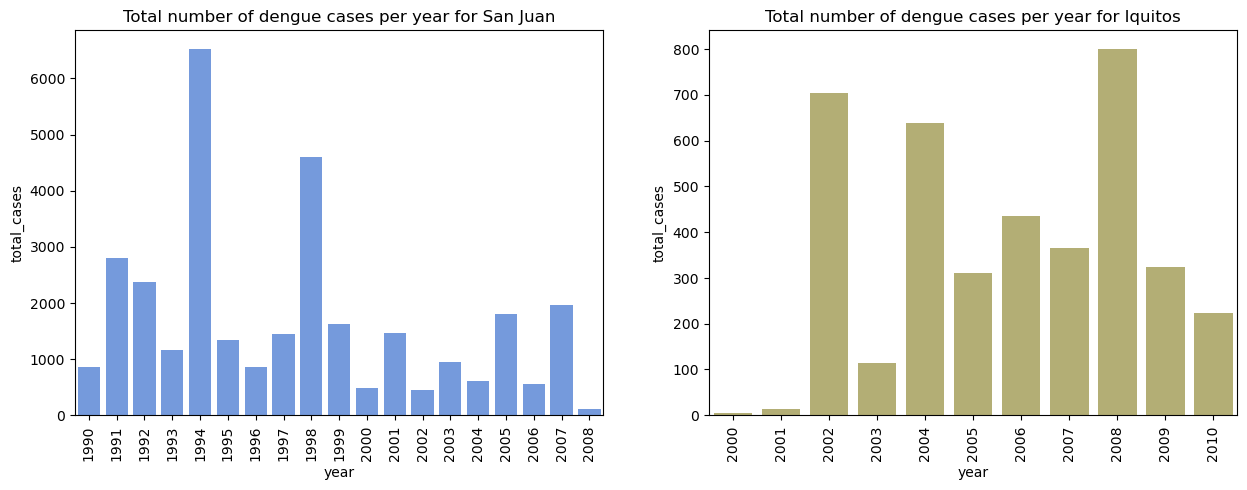

In [5]:
fig, axs = plt.subplots(1,2, figsize=(15,5))
g1 = sns.barplot(data=df_train_labels_sj.groupby(['year'])['total_cases'].sum().reset_index(), x='year',y='total_cases',color = 'cornflowerblue',ax=axs[0])
g1.set_xticklabels(g1.get_xticklabels(),rotation=90);
g1.set_title('Total number of dengue cases per year for San Juan');
g2 = sns.barplot(data=df_train_labels_iq.groupby(['year'])['total_cases'].sum().reset_index(), x='year',y='total_cases',color = 'darkkhaki',ax=axs[1])
axs[1].set_title('Total number of dengue cases per year for Iquitos')
g2.set_xticklabels(g2.get_xticklabels(),rotation=90);

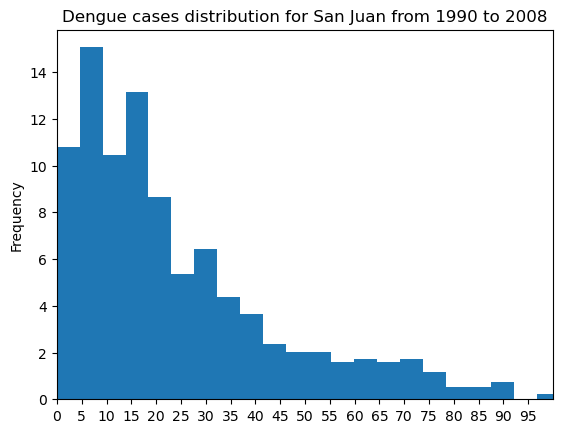

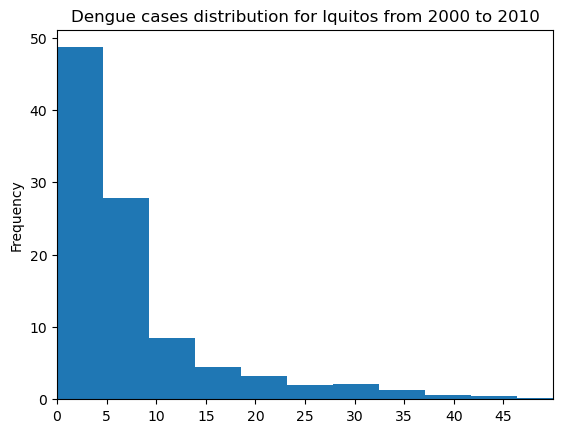

In [6]:
df = df_train_labels.loc[df_train_labels['city']=='sj','total_cases']
df.plot.hist(weights=100*np.ones_like(df)/len(df),bins=100)
plt.xlim((0,100))
plt.xticks(range(0,100,5));
plt.title('Dengue cases distribution for San Juan from 1990 to 2008');

plt.figure()
df = df_train_labels.loc[df_train_labels['city']=='iq','total_cases']
df.plot.hist(weights=100*np.ones_like(df)/len(df),bins=25)
plt.xlim((0,50))
plt.xticks(range(0,50,5));
plt.title('Dengue cases distribution for Iquitos from 2000 to 2010');

### Feature understanding

In [7]:
df_train_features.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [8]:
print('Number of total columns:',len(df_train_features.columns),'\n')
print(list(df_train_features.columns),'\n')
print('Number of useable features:', len(df_train_features.drop(['city', 'year', 'weekofyear', 'week_start_date'],axis=1).columns),'\n')
print('Info for iq = Iquitos and sj = San Juan:')
display(pd.DataFrame({
    'no. of observations (train)': df_train_features.groupby('city').size(),
    'from (train)': df_train_features.groupby('city')['year'].min(),
    'to (train)': df_train_features.groupby('city')['year'].max(),
    'no. of years (train)':df_train_features.groupby('city')['year'].nunique(),
    'no. of observations (test)': df_test_features.groupby('city').size(),
    'from (test)': df_test_features.groupby('city')['year'].min(),
    'to (test)': df_test_features.groupby('city')['year'].max(),
    'no. of years (test)':df_test_features.groupby('city')['year'].nunique(),
    'no. of dengues cases':df_train_labels.groupby('city')['total_cases'].sum(),
    'avg no. of dengues cases per week':df_train_labels.groupby('city')['total_cases'].mean()}))

Number of total columns: 24 

['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k', 'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k', 'reanalysis_precip_amt_kg_per_m2', 'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm', 'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k', 'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c', 'station_min_temp_c', 'station_precip_mm'] 

Number of useable features: 20 

Info for iq = Iquitos and sj = San Juan:


,no. of observations (train),from (train),to (train),no. of years (train),no. of observations (test),from (test),to (test),no. of years (test),no. of dengues cases,avg no. of dengues cases per week
city,,,,,,,,,,
iq,520,2000,2010,11,156,2010,2013,4,3934,7.565385
sj,936,1990,2008,19,260,2008,2013,6,31993,34.180556


In [9]:
useable_features = list(df_train_features.drop(['city','weekofyear','week_start_date','year'],axis=1).columns)

### Feature Description

In [10]:
ndvi = [x for x in list(df_train_features.columns) if 'ndvi' in x] 
reanalysis = [x for x in list(df_train_features.columns) if 'reanalysis' in x]
precip = [x for x in list(df_train_features.columns) if 'precipitation' in x]
station = [x for x in list(df_train_features.columns) if 'station' in x]
all_features = [ndvi,reanalysis,precip,station]
max_len = max([len(i) for i in all_features])
for i in range(len(all_features)):
    if len(all_features) < max_len:
        all_features[i] += [''] * (max_len - len(all_features[i]))

display(pd.DataFrame({
    'CDR Normalized Difference Vegetation Index':all_features[0],
    'NCEP Climate Forecast System Reanalysis':all_features[1],
    'CDR PERSIANN Precipitation Product':all_features[2],
    'GHCN daily climate data':all_features[3]}))

,CDR Normalized Difference Vegetation Index,NCEP Climate Forecast System Reanalysis,CDR PERSIANN Precipitation Product,GHCN daily climate data
0,ndvi_ne,reanalysis_air_temp_k,precipitation_amt_mm,station_avg_temp_c
1,ndvi_nw,reanalysis_avg_temp_k,,station_diur_temp_rng_c
2,ndvi_se,reanalysis_dew_point_temp_k,,station_max_temp_c
3,ndvi_sw,reanalysis_max_air_temp_k,,station_min_temp_c
4,,reanalysis_min_air_temp_k,,station_precip_mm
5,,reanalysis_precip_amt_kg_per_m2,,
6,,reanalysis_relative_humidity_percent,,
7,,reanalysis_sat_precip_amt_mm,,
8,,reanalysis_specific_humidity_g_per_kg,,
9,,reanalysis_tdtr_k,,


### Distribution of Features

#### Vegetation

In [11]:
def plot_distributions(ls,w,h,ft,r,c,feature,sharey=False):
    l = [x for x in ls if x != '']
    fig,axs = plt.subplots(nrows=r, ncols=c,figsize=(w,h),sharey=sharey)
    if hasattr(axs, "__len__"):
        axs = axs.flatten()
        for i,a in zip(l,axs):
            sns.boxplot(data=df_train_features, y=i, x="city",ax=a)
    else:
        for i in l:
            sns.boxplot(data=df_train_features, y=i, x="city",ax=axs)
    fig.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle('Distribution of '+ feature +' features for both San Juan and Iquitos', fontsize = ft)

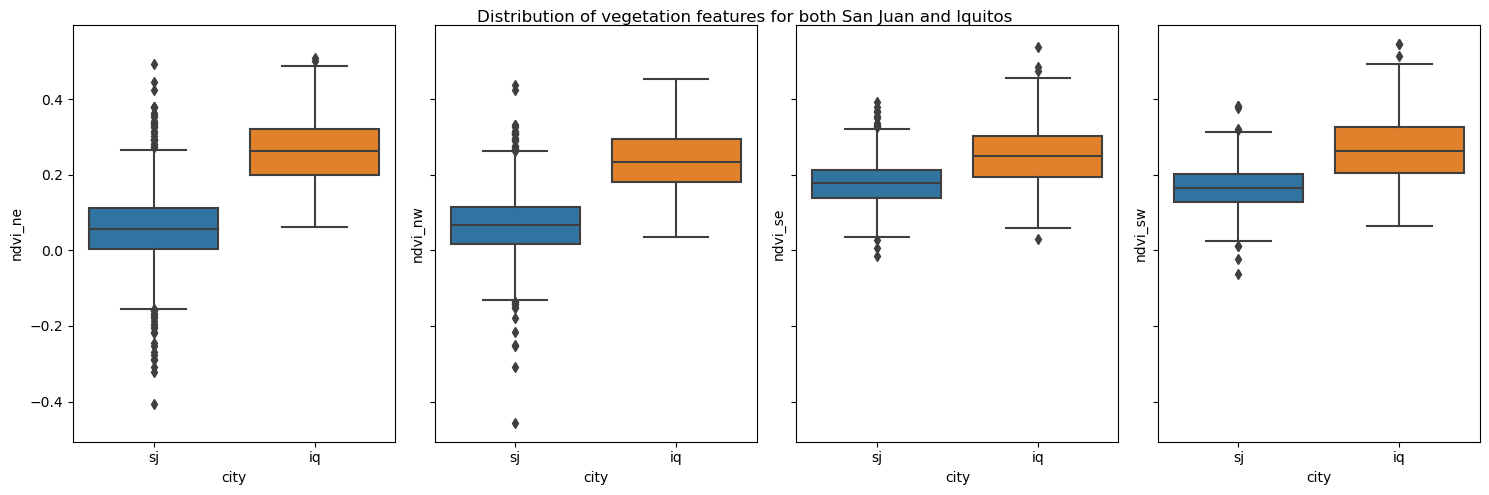

In [12]:
plot_distributions(ndvi,15,5,12,1,4,'vegetation',True)

There seems to be more vegetation in Iquitos compared to San Juan. Iquitos also seems to have fewer water bodies (cases where ndvi < 0). There are outlier areas in ndvi where there is more vegetation. 

In [13]:
sj_correlations = pd.concat([df_train_features_sj.loc[:,useable_features],df_train_labels_sj.loc[:,'total_cases']],axis=1).corr()
iq_correlations = pd.concat([df_train_features_iq.loc[:,useable_features],df_train_labels_iq.loc[:,'total_cases']],axis=1).corr()

In [14]:
def corr_heatmap(var,var_list,w=25,h=10):
    fig, axs = plt.subplots(1,2, figsize=(w,h))
    for i,j,k in zip(range(2),[sj_correlations,iq_correlations],['San Juan','Iquitos']):
        sns.heatmap(j.reset_index().loc[(j.reset_index()['index'].str.contains(var)|j.reset_index()['index'].str.contains("total_cases")),
                                                  [x for x in var_list if x != '']+['index']+['total_cases']].set_index('index'),
               cmap="crest",annot=True,ax=axs[i]);
    
        axs[i].title.set_text(k);
    fig.tight_layout()
    sns.set(style="whitegrid", font_scale=2.5)


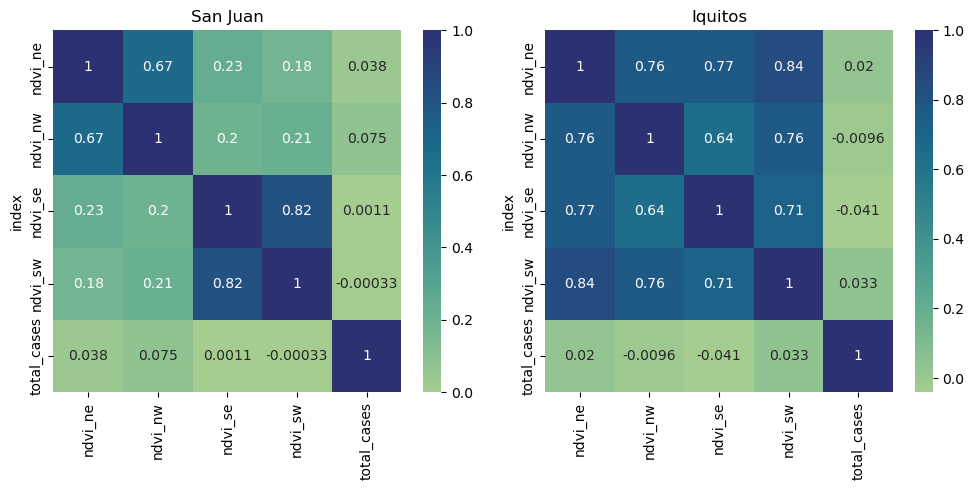

In [15]:
corr_heatmap('ndvi',ndvi,10,5)
matplotlib.rc_file_defaults()

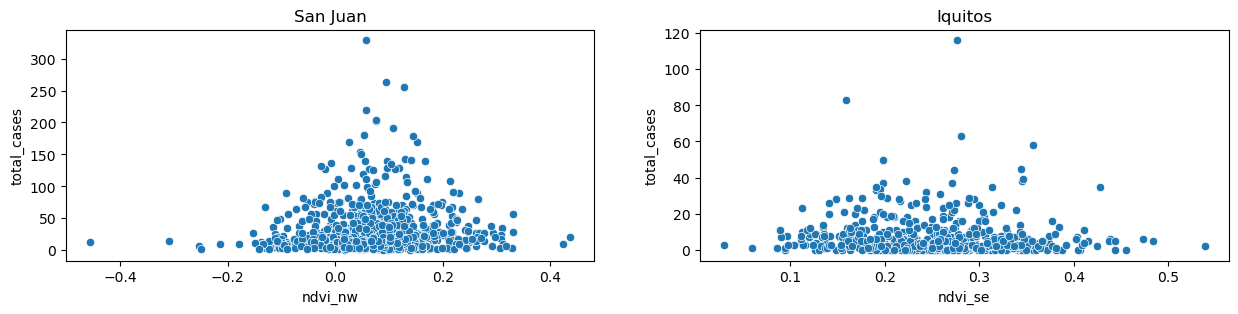

In [16]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
sns.scatterplot(x="ndvi_nw", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="ndvi_se", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Reanalysis 

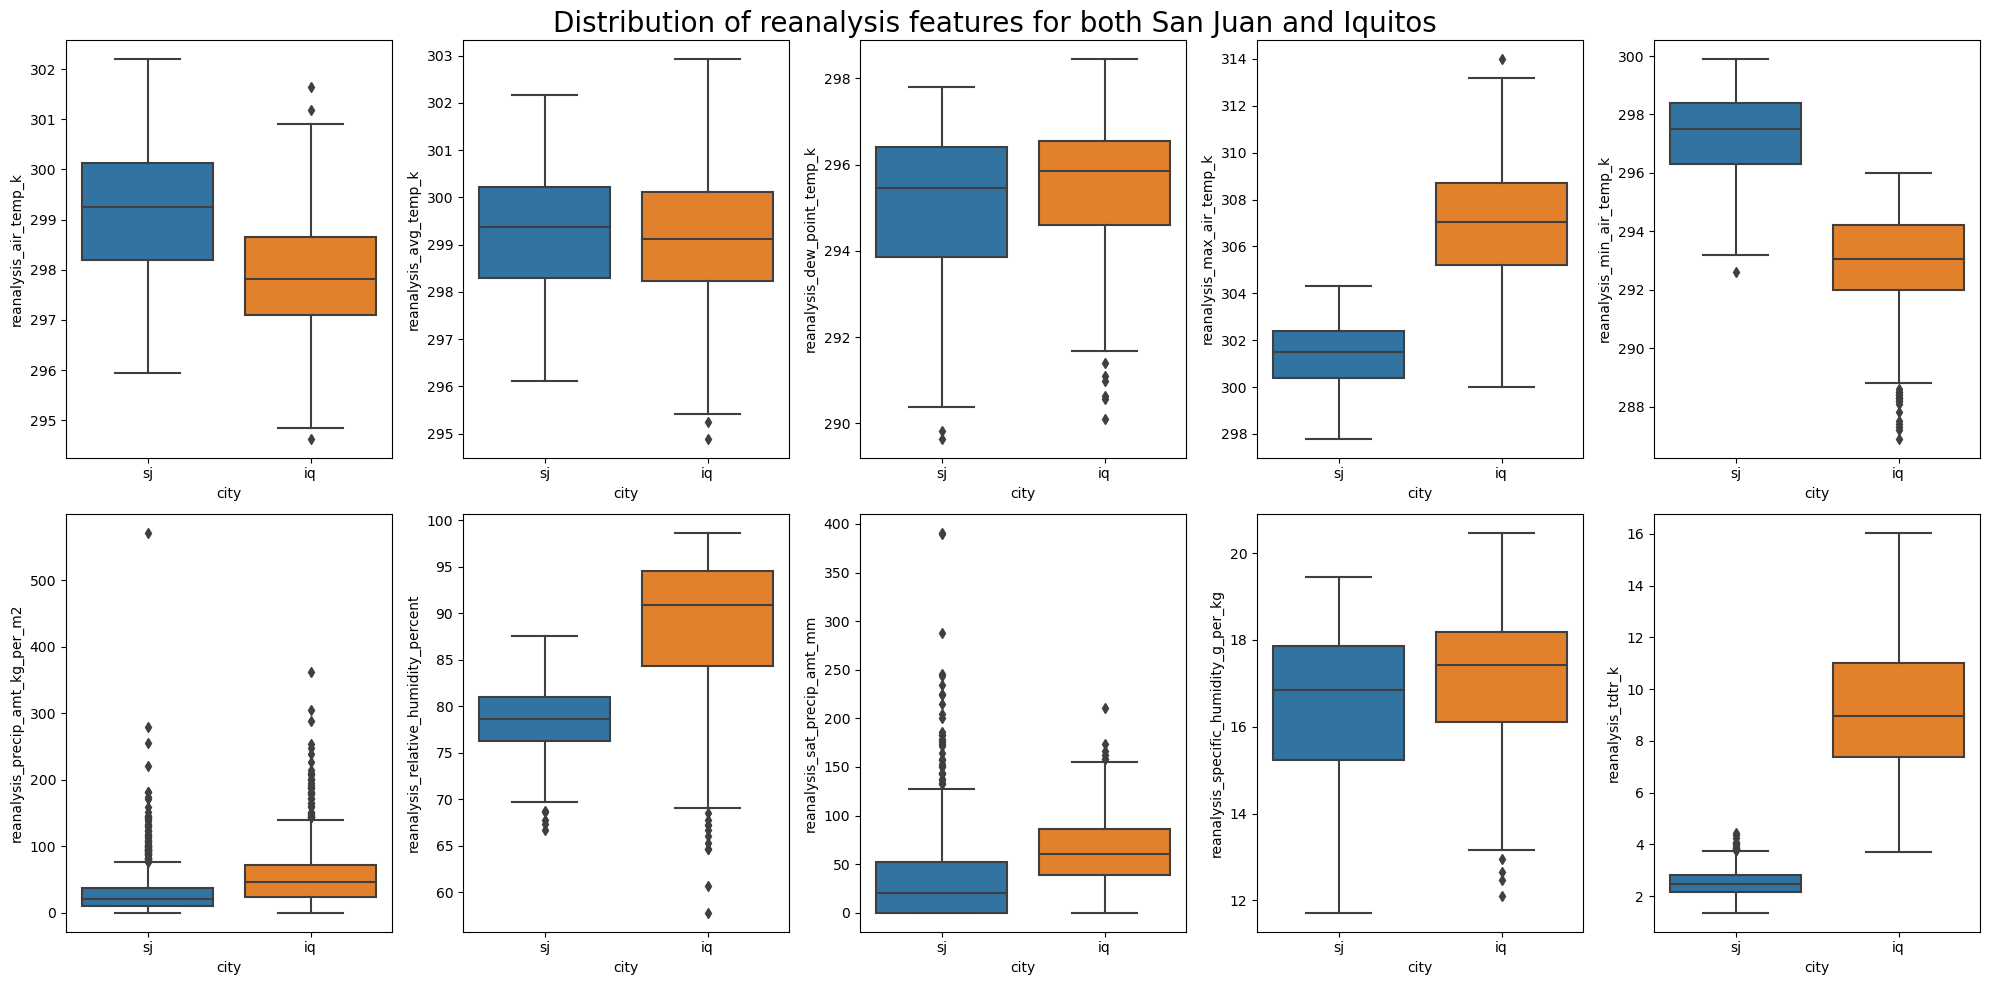

In [17]:
plot_distributions(reanalysis,20,10,20,2,5,'reanalysis')

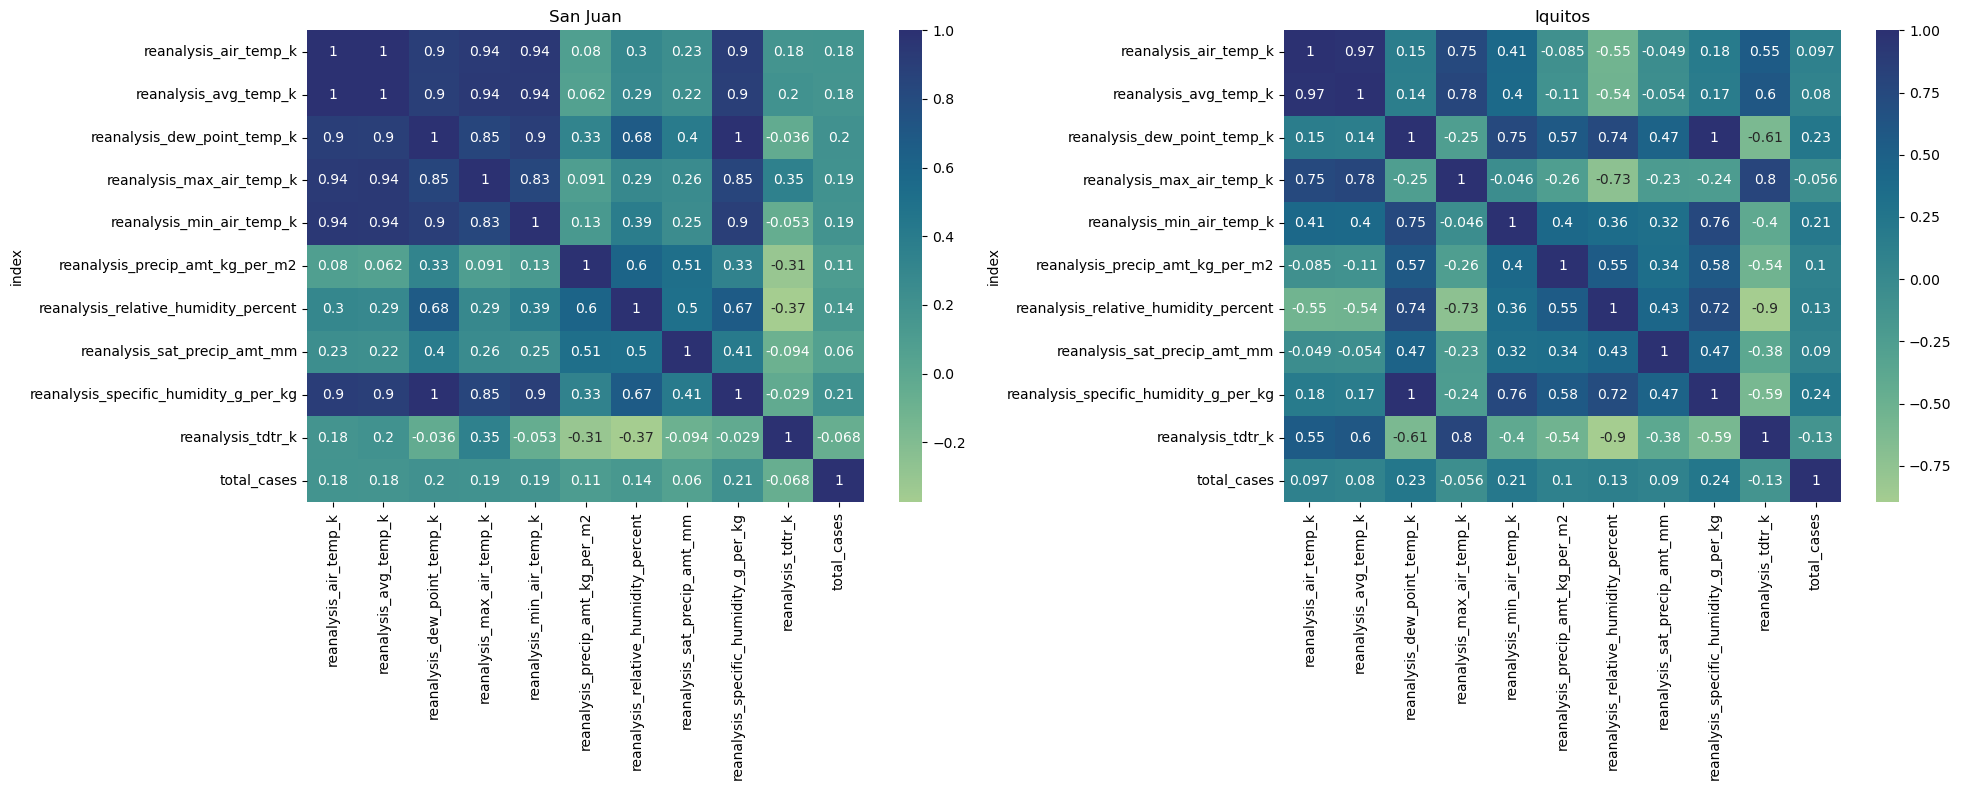

In [18]:
var = 'reanalysis'
var_list = reanalysis
corr_heatmap('reanalysis',reanalysis,20,8)
matplotlib.rc_file_defaults()

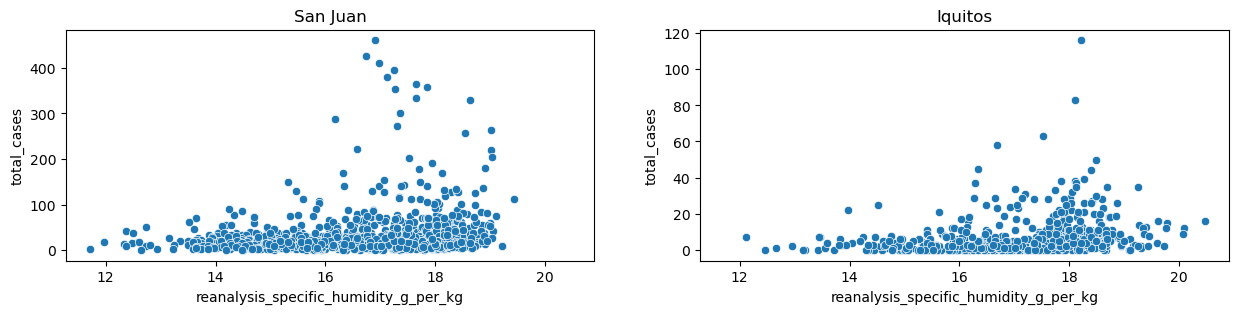

In [19]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="reanalysis_specific_humidity_g_per_kg", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Precipitation

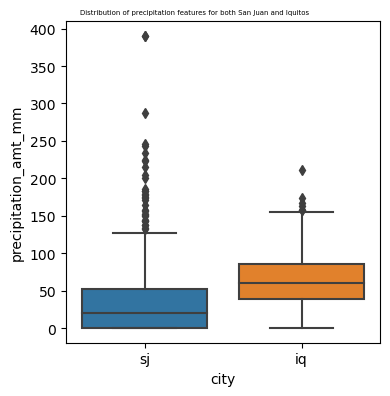

In [20]:
plot_distributions(precip,4,4,5,1,1,'precipitation')

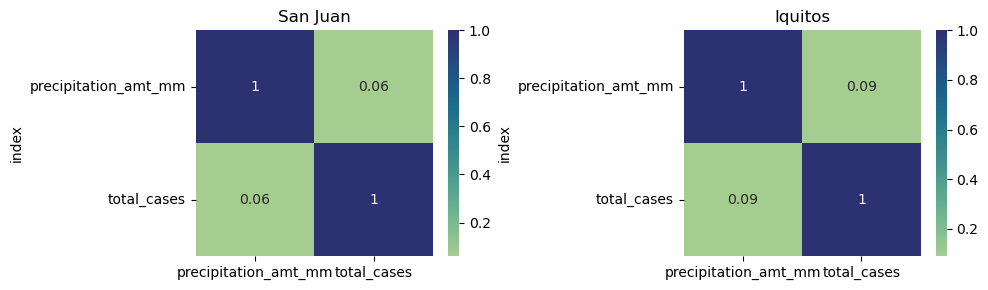

In [21]:
corr_heatmap('precipitation',precip,10,3)
matplotlib.rc_file_defaults()

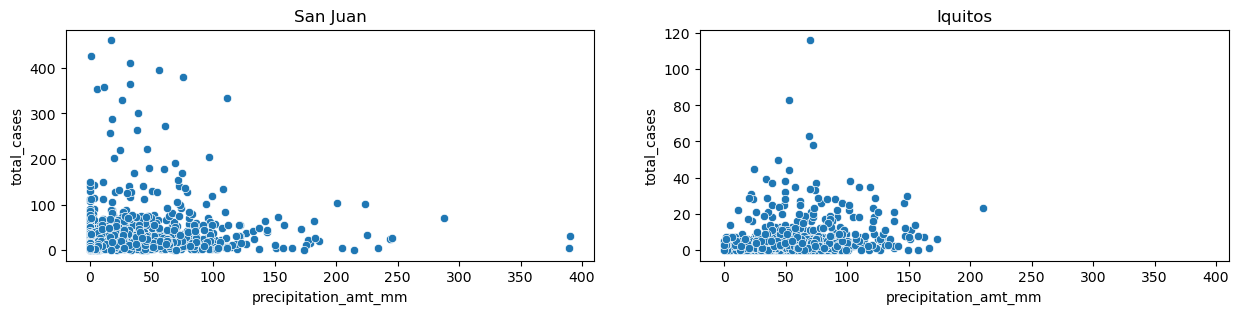

In [22]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="precipitation_amt_mm", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="precipitation_amt_mm", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

#### Climate

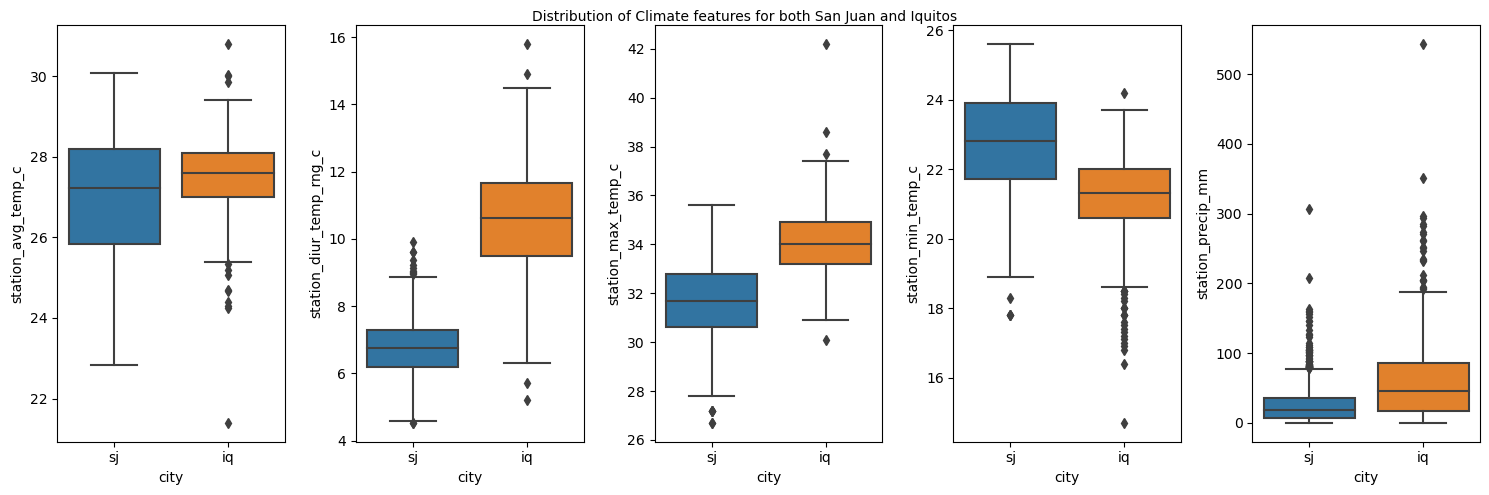

In [23]:
plot_distributions(station,15,5,10,1,5,'Climate')

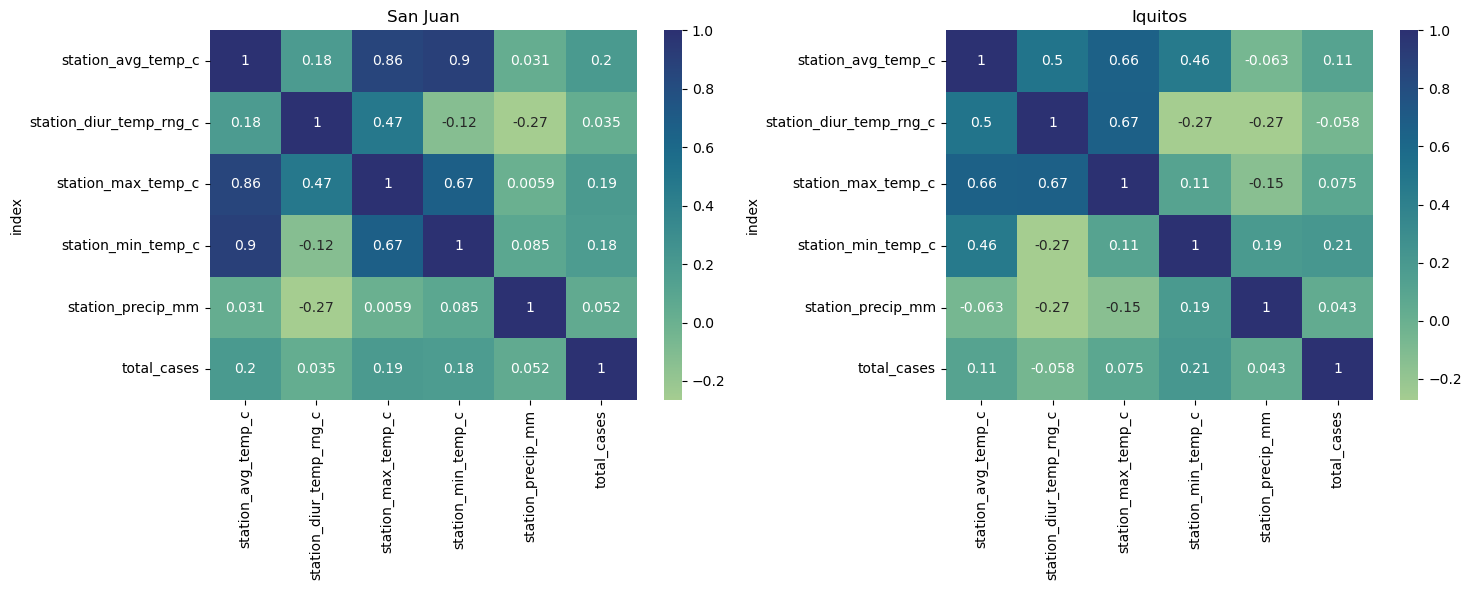

In [24]:
corr_heatmap('station',station,15,6)
matplotlib.rc_file_defaults()

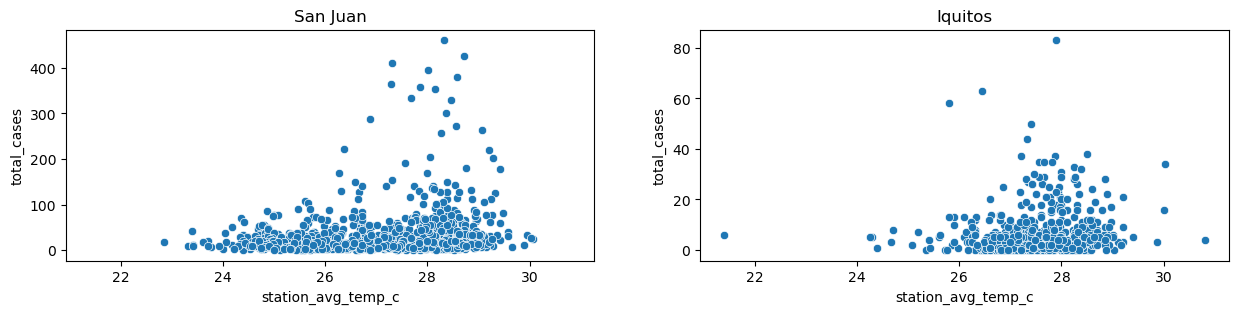

In [25]:
fig, axs = plt.subplots(1,2, figsize=(15,3), sharex=True)
sns.scatterplot(x="station_avg_temp_c", y="total_cases", data=pd.concat([df_train_features_sj,df_train_labels_sj],axis=1),ax=axs[0]);
sns.scatterplot(x="station_avg_temp_c", y="total_cases", data=pd.concat([df_train_features_iq,df_train_labels_iq],axis=1),ax=axs[1]);
axs[0].title.set_text('San Juan');
axs[1].title.set_text('Iquitos');

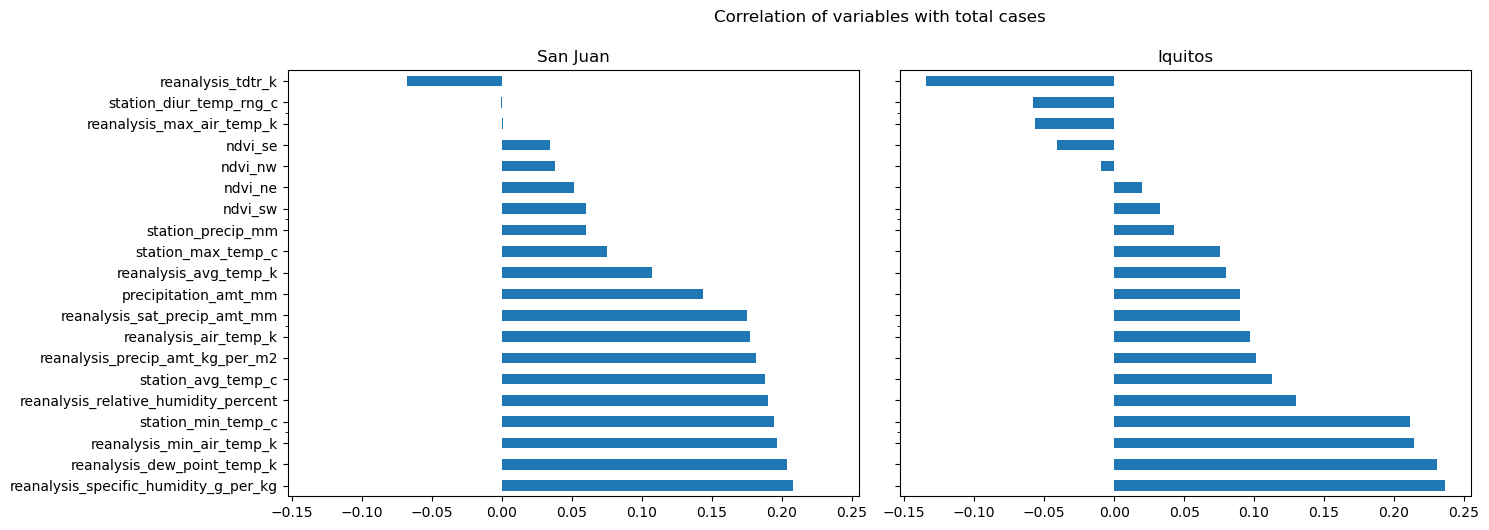

In [26]:
# reference: https://github.com/drivendata/benchmarks/blob/master/dengue-benchmark-statsmodels.ipynb
fig, axs = plt.subplots(1,2, figsize=(15,5),sharey=True,sharex=True)
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh(ax=axs[0]))
axs[0].title.set_text('San Juan');
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh(ax=axs[1]))
axs[1].title.set_text('Iquitos');
fig.tight_layout();
fig.suptitle('Correlation of variables with total cases',x=0.59,y=1.05);

### Sanity Checks

In [27]:
### there are no unique values set as a placeholder for missing values e.g. -9999
display(df_train_features['precipitation_amt_mm'].value_counts(1).sort_index(ascending=False).reset_index().loc[0:2,])
display(df_train_features['station_precip_mm'].value_counts(1).sort_index(ascending=False).reset_index().loc[0:2,])

,index,precipitation_amt_mm
0,390.60,0.000693
1,389.60,0.000693
2,287.55,0.000693


,index,station_precip_mm
0,543.3,0.000697
1,350.9,0.000697
2,305.9,0.000697


In [28]:
## See if there are longer than 9 days of gaps in the data (making sure that we have weekly data)
dg = df_train_features.copy()
dg['diff'] = pd.to_datetime(df_train_features['week_start_date']).diff().dt.days
dg.loc[dg['diff']>9,['city', 'year','week_start_date','diff']]

,city,year,week_start_date,diff


In [29]:
print('San Juan')
#any year with 0 cases?
display(pd.DataFrame(df_train_labels_sj.groupby('year')['total_cases'].sum()).transpose())
#check for the year that has lowest number of cases. How many weeks of data do we have for that year
display(df_train_labels_sj.loc[df_train_labels_sj['year']==2008,['year','weekofyear','total_cases']].reset_index(drop=True).transpose());

San Juan


year,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008
total_cases,866,2801,2371,1156,6533,1333,855,1454,4595,1633,492,1463,452,949,610,1805,550,1969,106


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
year,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008,2008
weekofyear,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
total_cases,15,14,15,10,9,2,6,8,5,1,2,3,4,3,1,3,5


In [30]:
print('Iquitos')
#any year with 0 cases?
display(pd.DataFrame(df_train_labels_iq.groupby('year')['total_cases'].sum()).transpose())
#check for the year that has lowest number of cases. How many weeks of data do we have for that year
display(df_train_labels_iq.loc[df_train_labels_iq['year']==2000,['year','weekofyear','total_cases']].reset_index(drop=True).transpose());

Iquitos


year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010
total_cases,4,14,704,114,638,311,436,365,801,324,223


,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
year,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
weekofyear,26,27,28,29,30,31,32,33,34,35,...,42,43,44,45,46,47,48,49,50,51
total_cases,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [31]:
percent_missing_sj = 100*df_train_features_sj.isnull().sum()/len(df_train_features_sj)
percent_missing_iq = 100*df_train_features_iq.isnull().sum()/len(df_train_features_iq)
df_missing_stats = pd.DataFrame({'precent_missing_sj' : percent_missing_sj, 
                                 'precent_missing_iq' : percent_missing_iq})
df_missing_stats.transpose()

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
precent_missing_sj,0.0,0.0,0.0,0.0,0.0,20.405983,5.235043,2.029915,2.029915,0.961538,...,0.641026,0.641026,0.961538,0.641026,0.641026,0.641026,0.641026,0.641026,0.641026,0.641026
precent_missing_iq,0.0,0.0,0.0,0.0,0.0,0.576923,0.576923,0.576923,0.576923,0.769231,...,0.769231,0.769231,0.769231,0.769231,0.769231,7.115385,7.115385,2.692308,1.538462,3.076923


#### Year on year plot for ndvi_ne for San Juan

ndvi_ne is mostly missing for San Juan in year 1994 after 35th week

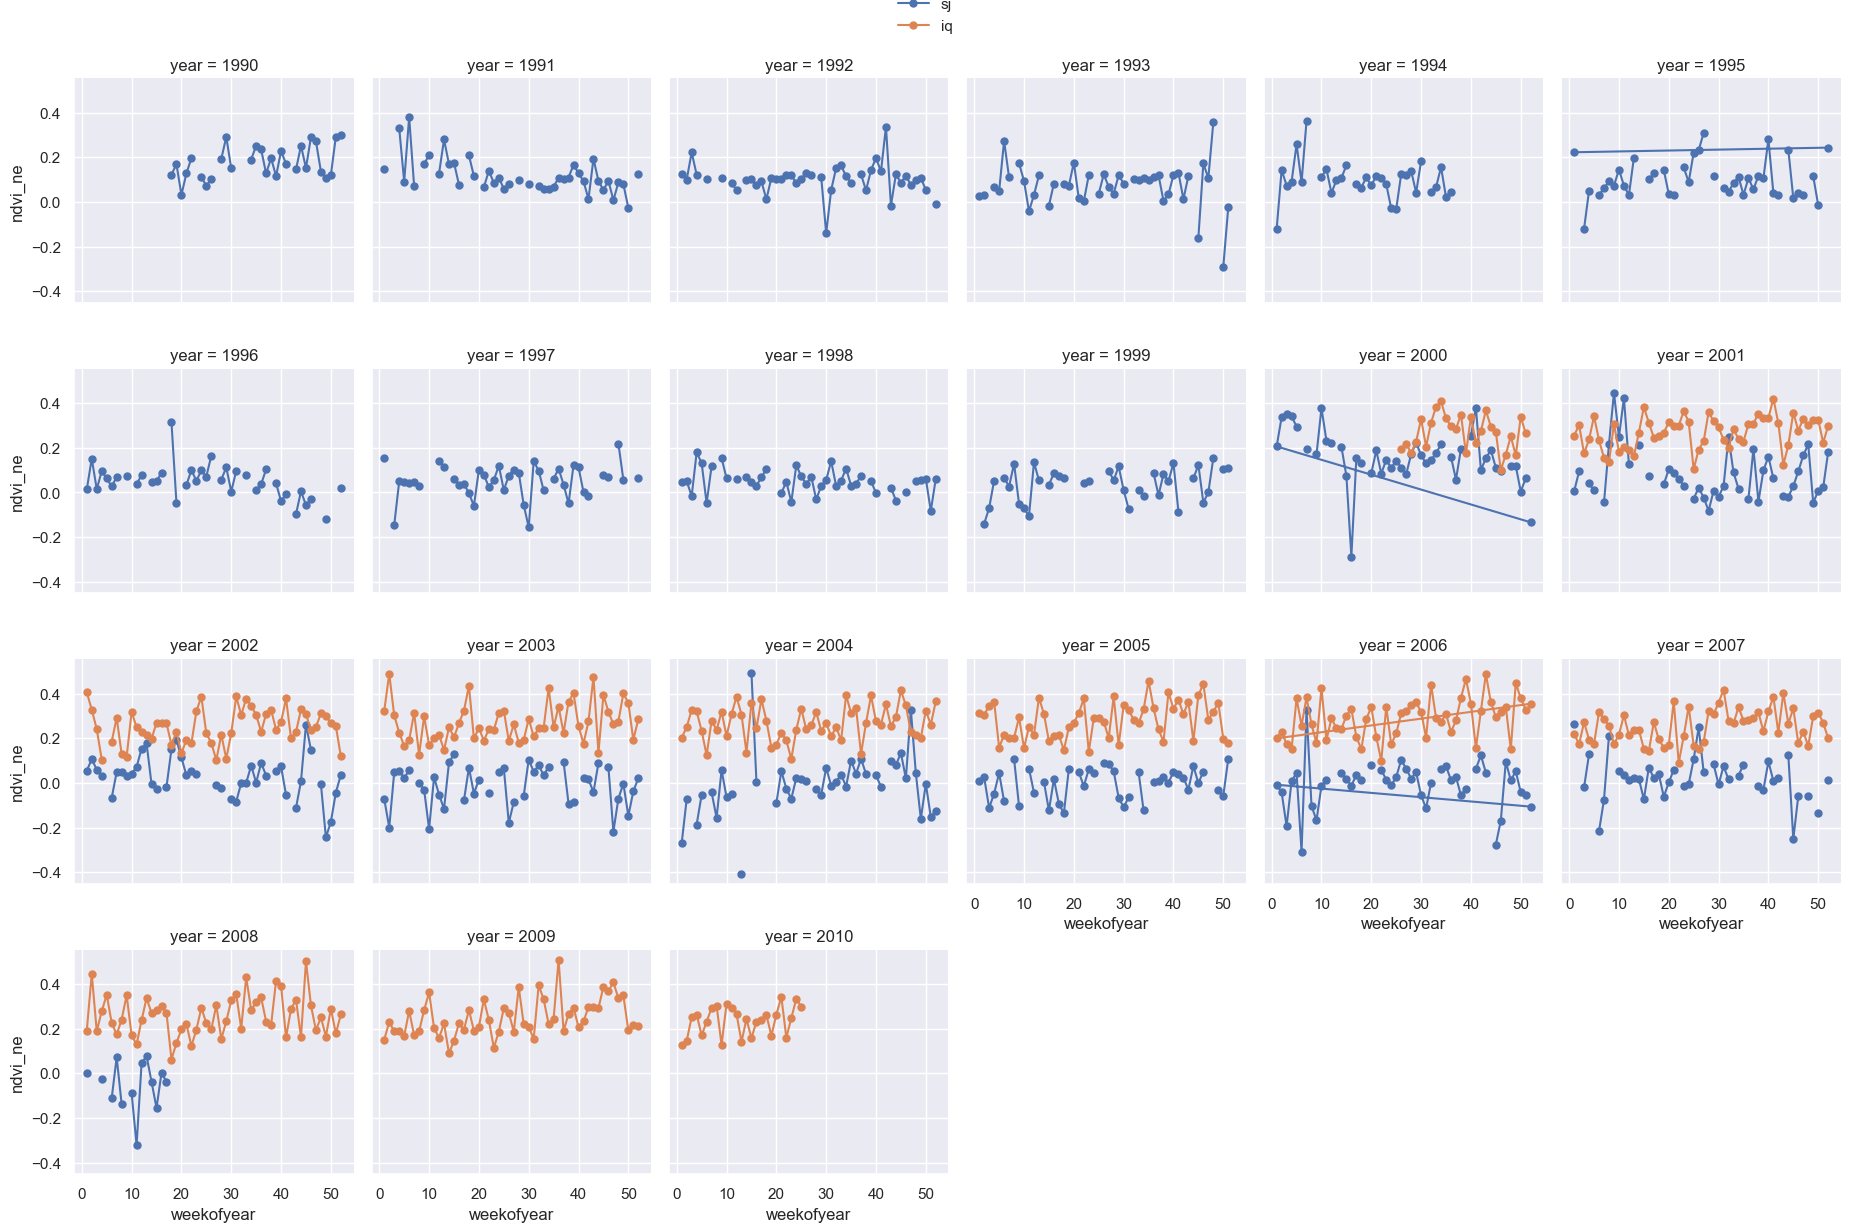

In [32]:
sns.set(rc={'figure.figsize':(20,35)})
graph = sns.FacetGrid(df_train_features,col='year', hue='city', col_wrap=6)
graph.map_dataframe(plt.plot,'weekofyear','ndvi_ne', marker = '.', markersize = 10).add_legend(loc='upper center',borderaxespad=-2)
plt.tight_layout()
plt.show()

ndvi_ne has 20% missing values for SJ so we will look at that. From the graph we see that year 1994 is missing after 35th week

Text(0.5, 1.0, 'ndvi_ne for San Juan for year 1994')

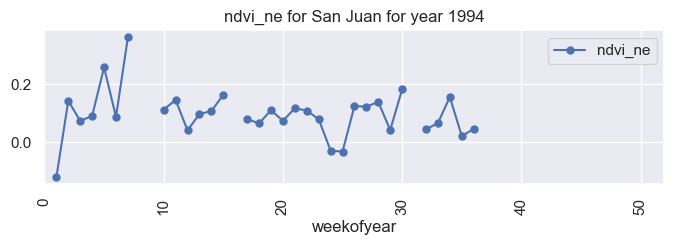

In [33]:
sns.set(rc={'figure.figsize':(8,2)})
df_train_features_sj.loc[(df_train_features_sj['year']==1994),][['weekofyear','ndvi_ne']].plot(x='weekofyear',y='ndvi_ne',rot=90,marker = '.', markersize = 10)
plt.xlim((0,52))
plt.title('ndvi_ne for San Juan for year 1994')

#### Year on year plot for station_avg_temp_c for Iquitos

station_avg_temp_c has 7% missing values for IQ so we will look at that. From the graph we see that year 2008 is the most problematic from 23rd to 30th week

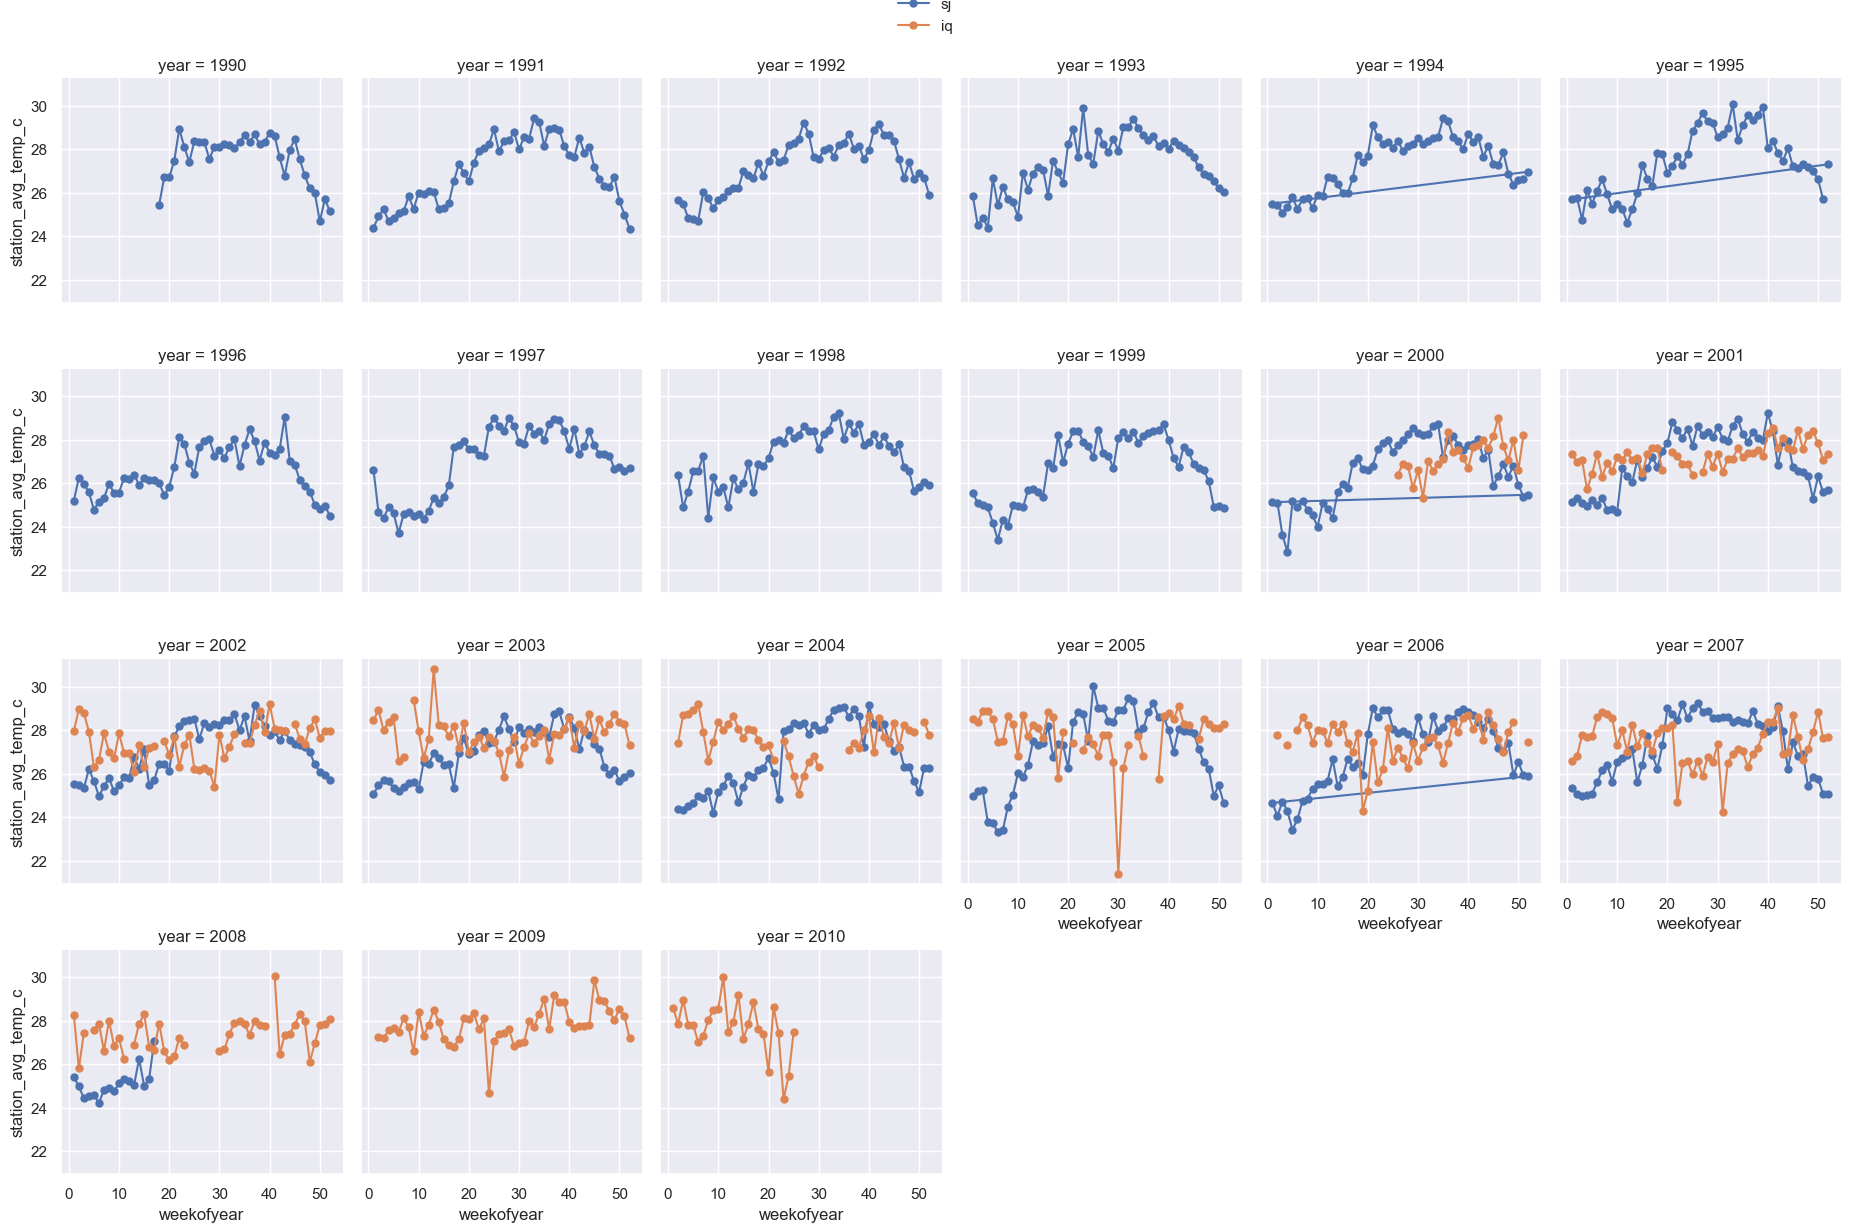

In [34]:
sns.set(rc={'figure.figsize':(20,35)})
graph = sns.FacetGrid(df_train_features,col='year', hue='city', col_wrap=6)
graph.map_dataframe(plt.plot,'weekofyear','station_avg_temp_c', marker = '.', markersize = 10).add_legend(loc='upper center',borderaxespad=-2)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'station_avg_temp_c for Iquitos for year 2008')

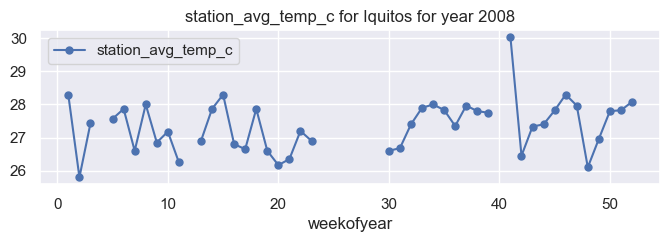

In [35]:
sns.set(rc={'figure.figsize':(8,2)})
df_train_features_iq.loc[(df_train_features_iq['year']==2008),][['weekofyear','station_avg_temp_c']].plot(x='weekofyear',y='station_avg_temp_c',marker = '.', markersize = 10)
plt.title('station_avg_temp_c for Iquitos for year 2008')

### Filling in Missing Values

Filling in all values with more than 1% missing values with ARIMA forecaster. Otherwise forward fill is used 

In [36]:
for i in range(len(useable_features)):
    if (df_missing_stats.reset_index().loc[df_missing_stats.reset_index()['index']==useable_features[i],'precent_missing_sj'].values[0] > 1):
        print(useable_features[i])
        result = adfuller(df_train_features_sj.loc[:,useable_features[i]].dropna())
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])

ndvi_ne
ADF Statistic: -5.125328
p-value: 0.000012
ndvi_nw
ADF Statistic: -2.892267
p-value: 0.046255
ndvi_se
ADF Statistic: -9.594164
p-value: 0.000000
ndvi_sw
ADF Statistic: -9.865577
p-value: 0.000000


In [37]:
for i in range(len(useable_features)):
    if (df_missing_stats.reset_index().loc[df_missing_stats.reset_index()['index']==useable_features[i],'precent_missing_iq'].values[0] > 1):
        print(useable_features[i])
        result = adfuller(df_train_features_iq.loc[:,useable_features[i]].dropna())
        print('ADF Statistic: %f' % result[0])
        print('p-value: %f' % result[1])

station_avg_temp_c
ADF Statistic: -6.072770
p-value: 0.000000
station_diur_temp_rng_c
ADF Statistic: -6.140134
p-value: 0.000000
station_max_temp_c
ADF Statistic: -7.501546
p-value: 0.000000
station_min_temp_c
ADF Statistic: -5.387557
p-value: 0.000004
station_precip_mm
ADF Statistic: -5.981924
p-value: 0.000000


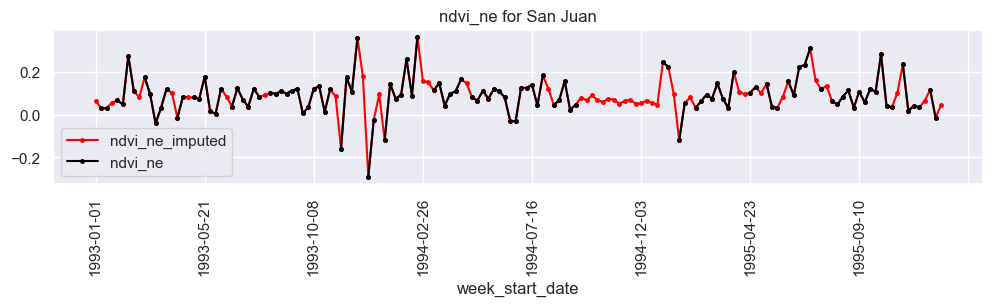

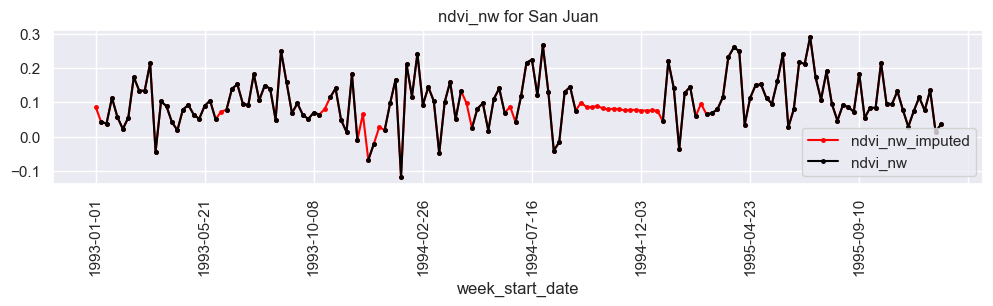

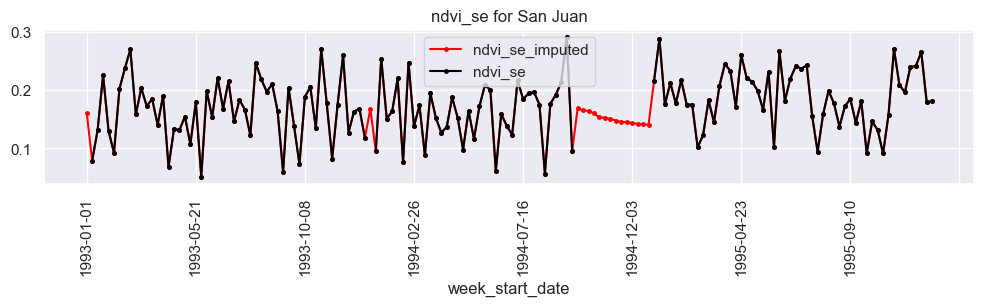

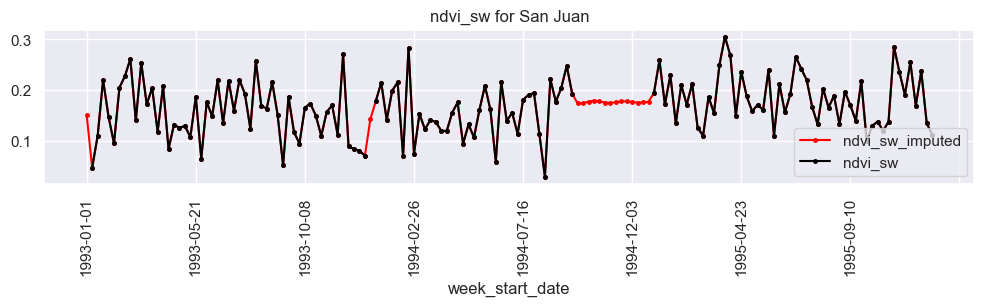

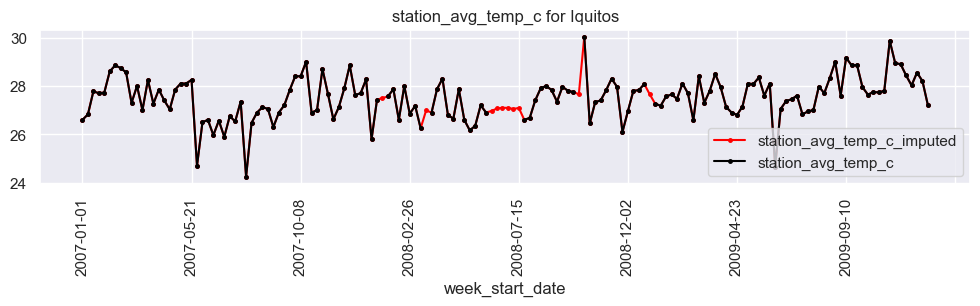

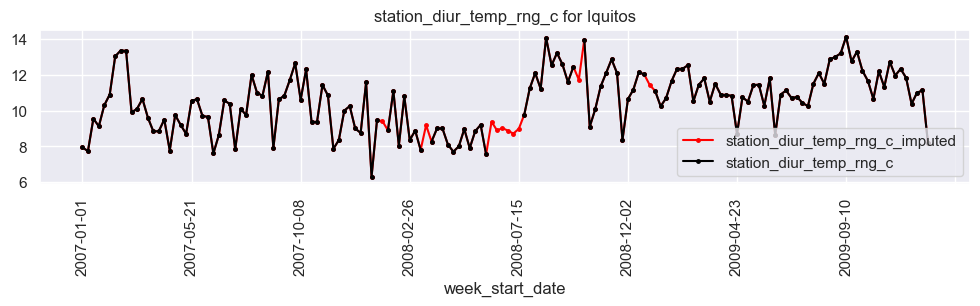

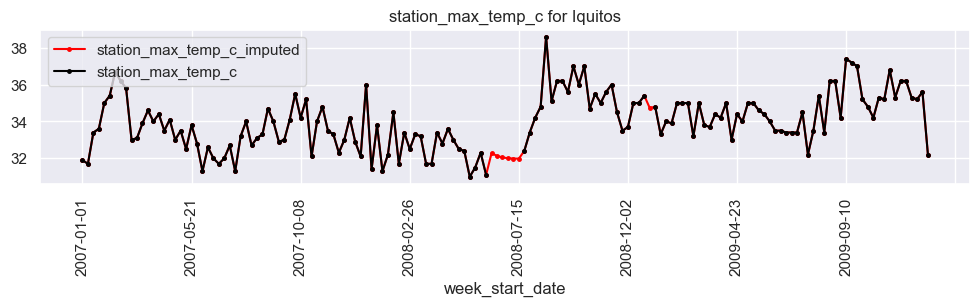

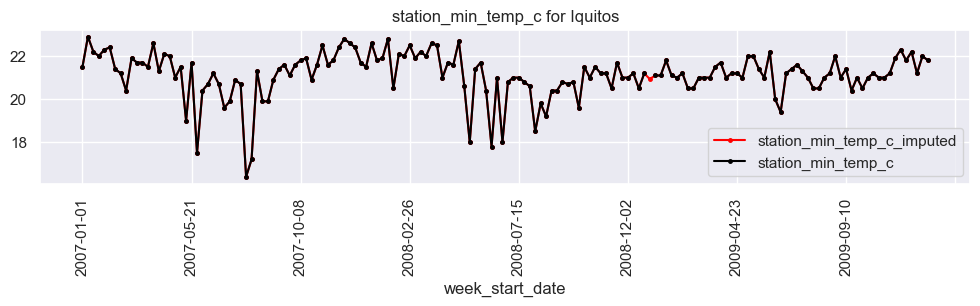

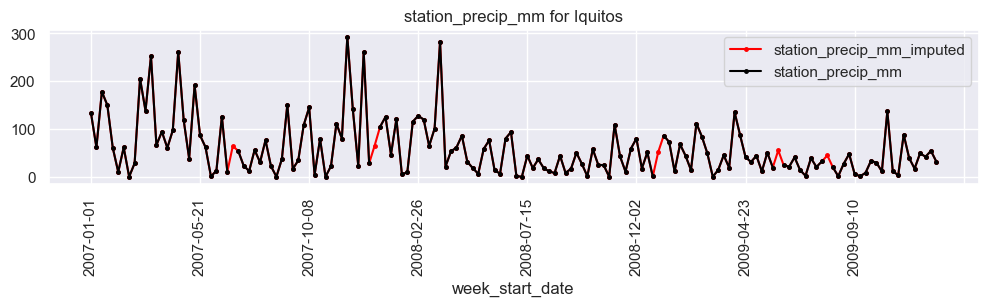

In [38]:
missing_threshold = 1
forecaster= ARIMA((4,0,4), suppress_warnings=True)

def impute(df,colname, plot_graphs=True):
    for i in range(len(df.columns)):
        #SELECTING VARIABLE TO IMPUTE
        var = df_missing_stats.reset_index().iloc[i,0]
        
        #IF IT'S MISSING PERCENTAGE IS > MISSING THRESHOLD THEN USE FORECASTER
        if (df_missing_stats.reset_index().loc[i,colname] > missing_threshold):
            transformer = Imputer(method="forecaster",forecaster=forecaster) #ARIMA FORECASTER
            df.loc[:,var+'_imputed'] = transformer.fit_transform(df.loc[:,var])
            
            
            #PLOTTING VEGETATION FIELDS FOR SAN JUAN
            if plot_graphs:
                if 'ndvi' in var and 'sj' in colname :
                    fig, ax = plt.subplots(figsize=(12,2));
                    plt.title(var+' for San Juan')
                    df.loc[((df['year']>=1993)&(df['year']<=1995)),][['week_start_date',var+'_imputed']].plot(ax=ax,x='week_start_date',y=var+'_imputed',marker = '.', markersize = 5,color='red',rot=90)
                    df.loc[((df['year']>=1993)&(df['year']<=1995)),][['week_start_date',var]].plot(ax=ax,x='week_start_date',y=var,marker = '.', markersize = 5,color='black', rot=90)

                #PLOTTING STATION FIELDS FOR IQUITOS
                if 'station' in var and 'iq' in colname :
                    fig, ax = plt.subplots(figsize=(12,2));
                    plt.title(var+' for Iquitos')
                    df.loc[((df['year']>=2007)&(df['year']<=2009)),][['week_start_date',var+'_imputed']].plot(ax=ax,x='week_start_date',y=var+'_imputed',marker = '.', markersize = 5,color='red',rot=90)
                    df.loc[((df['year']>=2007)&(df['year']<=2009)),][['week_start_date',var]].plot(ax=ax,x='week_start_date',y=var,marker = '.', markersize = 5,color='black', rot=90)
            df.drop(var, axis=1,inplace=True)
            df.loc[:,var] = df.loc[:,var+'_imputed']
            df.drop(var+'_imputed', axis=1,inplace=True)
        #IF MISSING % IS LESS THAN MISSING THRESHOLD THEN USE FORWARD FILL
        elif (df_missing_stats.reset_index().loc[i,colname] > 0) :
            df.loc[:,var] = df[var].fillna(method="ffill")
    return df


df_train_features_sj_imputed = impute(df_train_features_sj.copy(),'precent_missing_sj')
df_train_features_iq_imputed = impute(df_train_features_iq.copy(),'precent_missing_iq')
df_train_features_imputed = pd.concat([df_train_features_sj_imputed,df_train_features_iq_imputed])

### Train Test Split preparation

In [39]:
def hold_out_set(df_features,df_labels,label_col,split):
    all_features = df_features.columns
    train_size = int(len(df_features) * split)
    test_size = len(df_features) - train_size
    X_train, X_test = df_features.loc[0:train_size,all_features], df_features.loc[train_size:len(df_features),all_features]
    y_train, y_test = df_labels.loc[0:train_size,label_col], df_labels.loc[train_size:len(df_labels),label_col]
    #print('Train data: ', X_train.shape)
    #print('Test data: ', X_test.shape)
    
    return X_train, X_test, y_train, y_test

### Feature Importance from Random Forest (Using current week's data to predict number of cases)

Mean Absolute Error: 8
Mean Absolute Error: 35


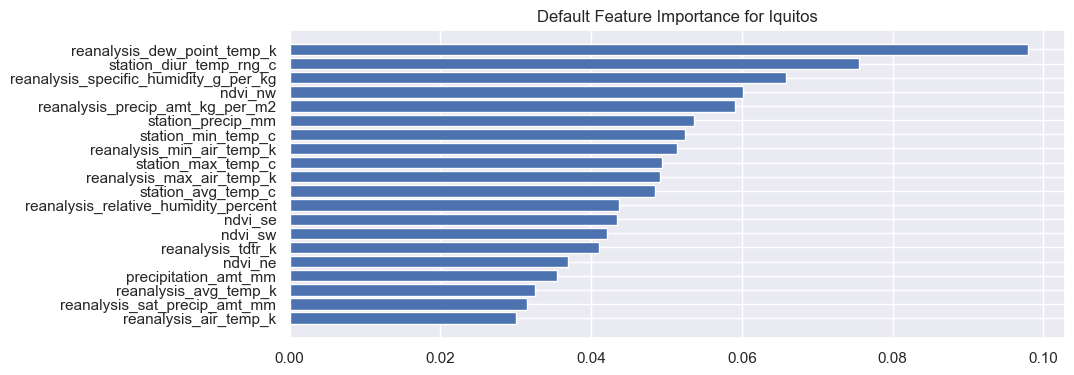

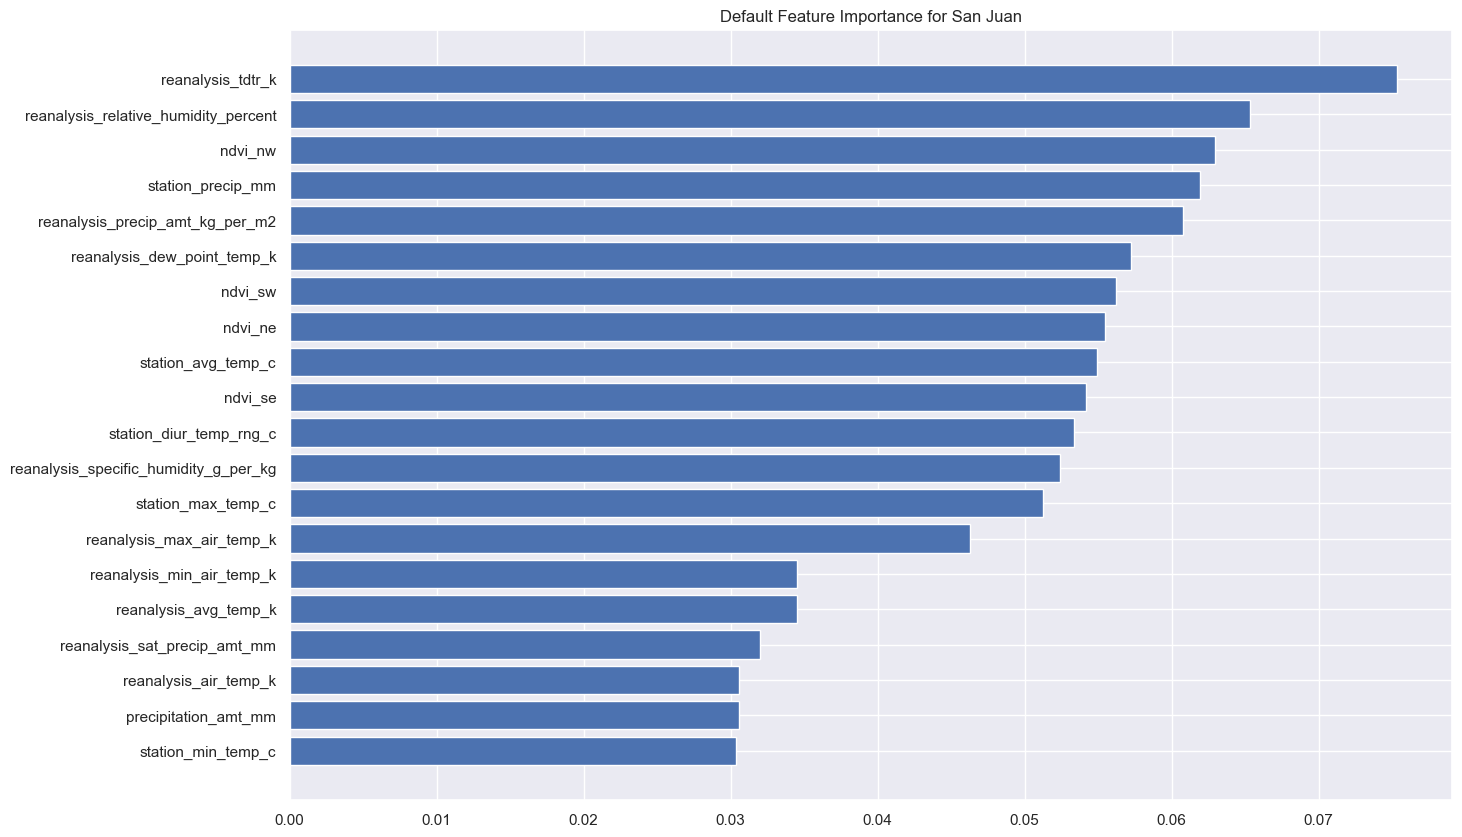

In [40]:
def feature_importance(df_train,df_labels,label_col,ttl,split):
    X_train, X_test, y_train, y_test = hold_out_set(df_train,df_labels,label_col,split)
    rf= RandomForestRegressor(n_estimators=100,criterion='absolute_error')
    split = TimeSeriesSplit(n_splits=5)
    score= cross_val_score(rf, X_train,y_train, cv=split, 
                           scoring='neg_mean_absolute_error')
    rf.fit(X_train, y_train)
    sorted_idx = rf.feature_importances_.argsort()
    all_features = X_train.columns
    g = plt.barh(all_features[sorted_idx], rf.feature_importances_[sorted_idx])
    plt.title('Default Feature Importance for '+ttl)
    
    #perm_importance = permutation_importance(rf, X_test, y_test)
    #sorted_idx = perm_importance.importances_mean.argsort()
    #g = plt.barh(all_features[sorted_idx], perm_importance.importances_mean[sorted_idx])
    #plt.xlabel("Permutation Importance")
    top_10_features = list(all_features[sorted_idx][-10:])

    predictions = rf.predict(X_test)
    errors = abs(predictions - y_test)
    print('Mean Absolute Error:', math.floor(np.mean(errors)))
    return rf,g,top_10_features


plt.figure(figsize=(10,4))
rf_iq_static, g, top_10_features_iq_static = feature_importance(df_train_features_iq_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),  
                                           df_train_labels_iq,'total_cases',
                                           'Iquitos',0.70)
plt.figure(figsize=(15,10))
rf_sj_static,g,top_10_features_sj_static = feature_importance(df_train_features_sj_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1), 
                                          df_train_labels_sj,'total_cases',
                                          'San Juan',0.70)


### Cross validation using different models

In [41]:
def pipeline_cross_val(df_features, df_labels,col,label='total_cases',split=0.70):
    X_train, X_test, y_train, y_test = hold_out_set(df_features,df_labels,label,split)

    split = TimeSeriesSplit(n_splits=5)
    models = { 'Linear Regression': linear_model.LinearRegression(),
             'RF': RandomForestRegressor(n_estimators=100,criterion='absolute_error',max_depth=4),
             'SVR': make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.5)),
             'Poisson Regressor': linear_model.PoissonRegressor(warm_start=True),
             'Bayesian Ridge': linear_model.BayesianRidge(),
             'Lasso': linear_model.LassoLars(alpha=.1, normalize=False)}
    train_scores = {}
    test_scores = {}

    best_score = -999999
    for key, value in models.items():
        score= cross_val_score(value, X_train,y_train, cv=split, 
                               scoring='neg_mean_absolute_error')
        value.fit(X_train, y_train)
        train_scores[key] = abs(score[-1])
        y_pred = value.predict(X_test)
        test_scores[key] = mae(y_test, y_pred)

    return pd.DataFrame.from_dict(train_scores, orient = 'index',columns=[col[0]]).join(pd.DataFrame.from_dict(test_scores, orient = 'index',columns=[col[1]]))  

### Prediction for San Juan using static data

San Juan:
Forward Filled Data:
Data imputed with ARIMA:
Only top 10 features used:


,trainScore_FFill,testScore_FFill,trainScore_ARIMA,testScore_ARIMA,trainScore_top10features,testScore_top10features
Linear Regression,33.745345,33.280636,32.529793,29.196670,33.057488,30.686200
RF,23.825229,22.446174,22.938211,21.612883,21.780872,20.916530
SVR,17.755999,18.368043,17.746326,18.329979,17.287417,18.435153
Poisson Regressor,31.539867,25.182110,29.810168,25.636850,27.755724,25.235177
Bayesian Ridge,28.014379,26.661617,28.005751,26.661054,28.157587,26.437676
Lasso,30.171983,27.034731,29.821567,27.251378,32.749134,28.185643


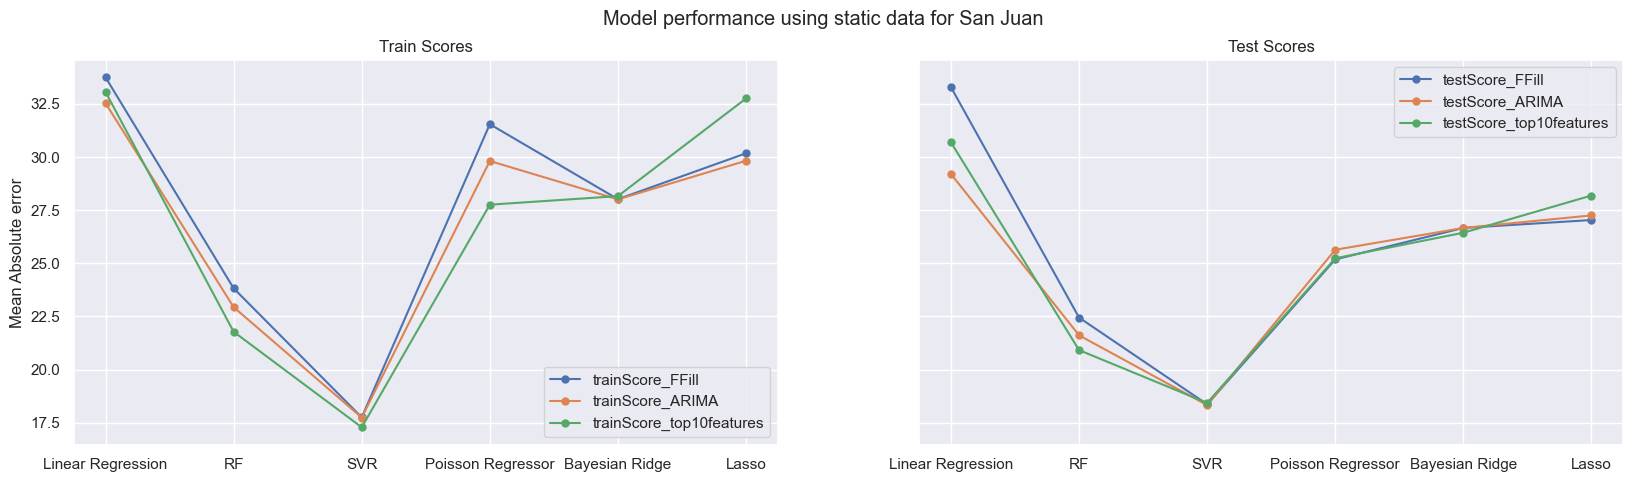

In [42]:
print('San Juan:')
print('Forward Filled Data:')
df_ffill = pipeline_cross_val(df_train_features_sj.fillna(method="ffill").drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_sj,['trainScore_FFill','testScore_FFill'])

print('Data imputed with ARIMA:')
df_arima = pipeline_cross_val(df_train_features_sj_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_sj,['trainScore_ARIMA','testScore_ARIMA'])


print('Only top 10 features used:')
df_top10 = pipeline_cross_val(df_train_features_sj_imputed[top_10_features_sj_static],
                   df_train_labels_sj,['trainScore_top10features','testScore_top10features'])
display(pd.concat([df_ffill,df_arima,df_top10],axis=1))

fig, axs = plt.subplots(1,2,sharey=True, sharex=True)
df = pd.concat([df_ffill,df_arima,df_top10],axis=1)
df.loc[:,[x for x in df.columns if 'train' in x]].plot(marker='.',markersize=10,ax=axs[0],figsize=(20,5));
df.loc[:,[x for x in df.columns if 'test' in x]].plot(marker='.',markersize=10,ax=axs[1],figsize=(20,5));
axs[0].set_ylabel('Mean Absolute error');
fig.suptitle('Model performance using static data for San Juan');
axs[0].set_title('Train Scores');
axs[1].set_title('Test Scores');

### Prediction for Iquitos using static data

Iquitos:
Forward Filled Data:
Data imputed with ARIMA:
Only top 10 features used:


,trainScore_FFill,testScore_FFill,trainScore_ARIMA,testScore_ARIMA,trainScore_top10features,testScore_top10features
Linear Regression,4.004173,7.438405,3.984435,7.429026,3.985931,7.275345
RF,3.226750,7.792724,3.342333,7.708590,3.098667,7.842244
SVR,2.715252,7.488533,2.731422,7.461290,2.995190,7.493739
Poisson Regressor,3.880183,7.459662,3.834298,7.473319,4.003011,7.366798
Bayesian Ridge,3.725062,7.619573,3.727294,7.626264,3.859532,7.420478
Lasso,3.945884,7.516061,3.792386,7.510525,4.130050,7.470039


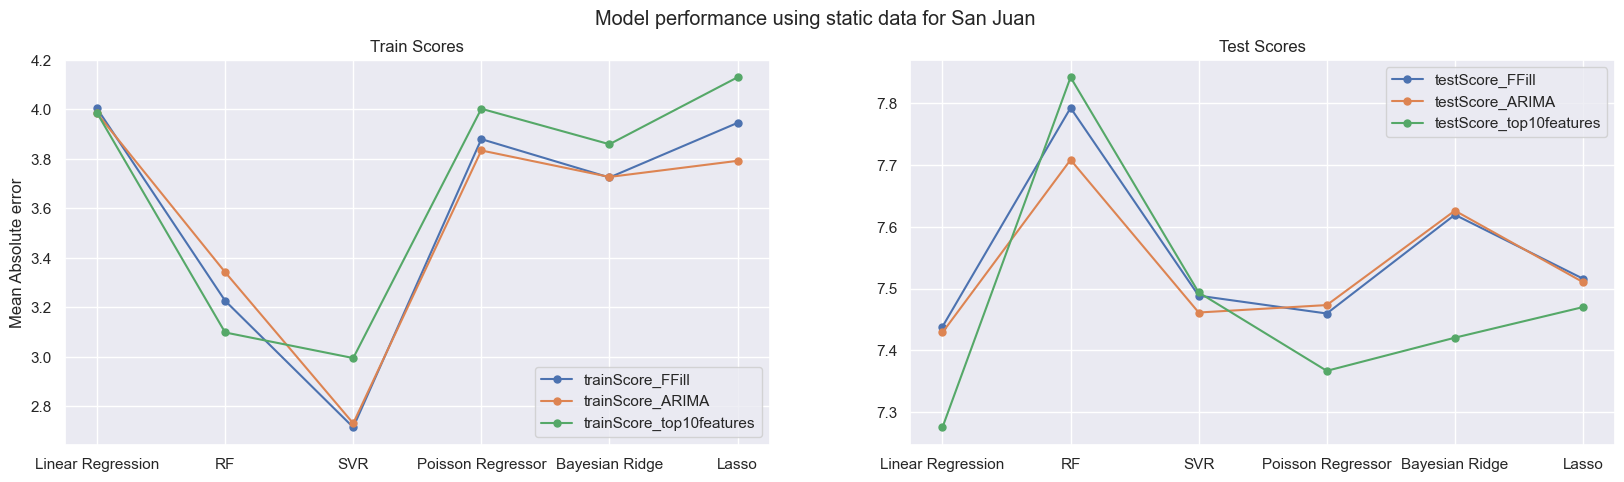

In [43]:
print('Iquitos:')
print('Forward Filled Data:')
df_ffill = pipeline_cross_val(df_train_features_iq.fillna(method="ffill").drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_iq,['trainScore_FFill','testScore_FFill'])

print('Data imputed with ARIMA:')
df_arima = pipeline_cross_val(df_train_features_iq_imputed.drop(['city','year','weekofyear', 'week_start_date', 'index'],axis=1),
                   df_train_labels_iq,['trainScore_ARIMA','testScore_ARIMA'])


print('Only top 10 features used:')
df_top10 = pipeline_cross_val(df_train_features_iq_imputed[top_10_features_iq_static],
                   df_train_labels_iq,['trainScore_top10features','testScore_top10features'])
display(pd.concat([df_ffill,df_arima,df_top10],axis=1))

fig, axs = plt.subplots(1,2, sharex=True)
df = pd.concat([df_ffill,df_arima,df_top10],axis=1)
df.loc[:,[x for x in df.columns if 'train' in x]].plot(marker='.',markersize=10,ax=axs[0],figsize=(20,5));
df.loc[:,[x for x in df.columns if 'test' in x]].plot(marker='.',markersize=10,ax=axs[1],figsize=(20,5));
axs[0].set_ylabel('Mean Absolute error');
fig.suptitle('Model performance using static data for San Juan');
axs[0].set_title('Train Scores');
axs[1].set_title('Test Scores');

### Time series forecasting

#### Prepare data

In [44]:
def window_function(df,features,target,lag,lead):
    lagged_cols, lagged_col_names = list(), list()
    for i in range(lag, 0, -1):
        lagged_cols.append(df.drop(target,axis=1).shift(i))
        lagged_col_names += [('%s(t-%d)' % (j, i)) for j in features]
    
    for i in range(0, lead):
        lagged_cols.append(df[target].shift(-i).fillna(0).astype(int))
        if i == 0:
            lagged_col_names += [(target+'(t)')]
        else:
            lagged_cols.append(df.drop(target,axis=1).shift(-i))
            lagged_col_names += [(target+'(t+%d)' % i)]
            lagged_col_names += [('%s(t)' % j) for j in features]
        
    shifted_df = pd.concat(lagged_cols, axis=1)
    shifted_df.columns = lagged_col_names
    shifted_df.dropna(inplace=True)
    return shifted_df

Using last week's data and current week's data to predict current week's number of dengue cases.<br>
<br>
e.g:
<br>
**FEATURES:**<br>
ndvi_ne(t-1) = Last week's vegetation index <br>
ndvi_ne(t) = This week's vegetation index <br>
no_of_cases(t) = Last week's dengue cases <br>
<br>
<br>
**TARGET:**<br>
no_of_cases(t+1) : This week's dengue cases

In [45]:
df_sj_time_series = df_train_features_sj_imputed.loc[:,top_10_features_sj_static]
df_sj_time_series['no_of_cases'] = df_train_labels_sj.loc[:,'total_cases']
df_sj_time_series = window_function(df_sj_time_series,top_10_features_sj_static, 'no_of_cases',1,1)
example_cols_present = [x for x in df_sj_time_series.columns if '(t)' in x]
example_cols_past = [x for x in df_sj_time_series.columns if '(t-1)' in x]
df_sj_time_series[example_cols_past[0:2]+example_cols_present[0:2]].head(2)

,ndvi_se(t-1),station_avg_temp_c(t-1),no_of_cases(t)
1,0.198483,25.442857,5
2,0.162357,26.714286,4


In [46]:
df_iq_time_series = df_train_features_iq_imputed.loc[:,top_10_features_iq_static]
df_iq_time_series['no_of_cases'] = df_train_labels_iq.loc[:,'total_cases']
df_iq_time_series = window_function(df_iq_time_series,top_10_features_iq_static, 'no_of_cases',1,1)
example_cols_present = [x for x in df_iq_time_series.columns if '(t)' in x]
example_cols_past = [x for x in df_iq_time_series.columns if '(t-1)' in x]
df_iq_time_series[example_cols_past[0:2]+example_cols_present[0:2]].head(2)

,reanalysis_max_air_temp_k(t-1),station_max_temp_c(t-1),no_of_cases(t)
1,307.3,32.5,0
2,306.6,34.0,0


### Prediction for San Juan using time series data

San Juan:
Time series Data:


,trainScore_timeseries,testScore_timeseries
Linear Regression,31.559900,31.069020
RF,21.948073,19.913209
SVR,17.261421,17.971386
Poisson Regressor,27.065980,24.916965
Bayesian Ridge,29.154843,26.556164
Lasso,31.695609,28.432935


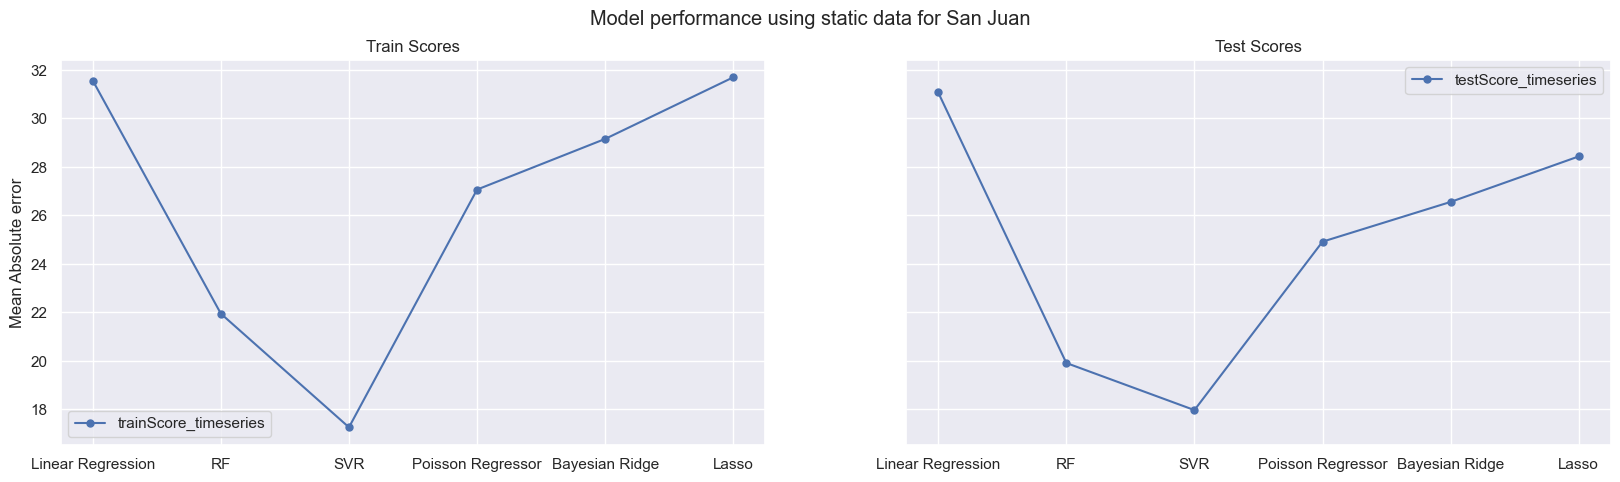

In [47]:
print('San Juan:')
print('Time series Data:')
df = pipeline_cross_val(df_sj_time_series.drop('no_of_cases(t)', axis=1),
                   df_sj_time_series,['trainScore_timeseries','testScore_timeseries'],'no_of_cases(t)')

display(df)

fig, axs = plt.subplots(1,2,sharey=True, sharex=True)

df.loc[:,[x for x in df.columns if 'train' in x]].plot(marker='.',markersize=10,ax=axs[0],figsize=(20,5));
df.loc[:,[x for x in df.columns if 'test' in x]].plot(marker='.',markersize=10,ax=axs[1],figsize=(20,5));
axs[0].set_ylabel('Mean Absolute error');
fig.suptitle('Model performance using static data for San Juan');
axs[0].set_title('Train Scores');
axs[1].set_title('Test Scores');

### Prediction for Iquitos using time series data

Iquitos:
Time series Data:


,trainScore_timeseries,testScore_timeseries
Linear Regression,3.807458,7.407530
RF,2.911917,7.687452
SVR,2.844027,7.548571
Poisson Regressor,3.672348,7.401341
Bayesian Ridge,3.484842,7.407723
Lasso,3.718890,7.488697


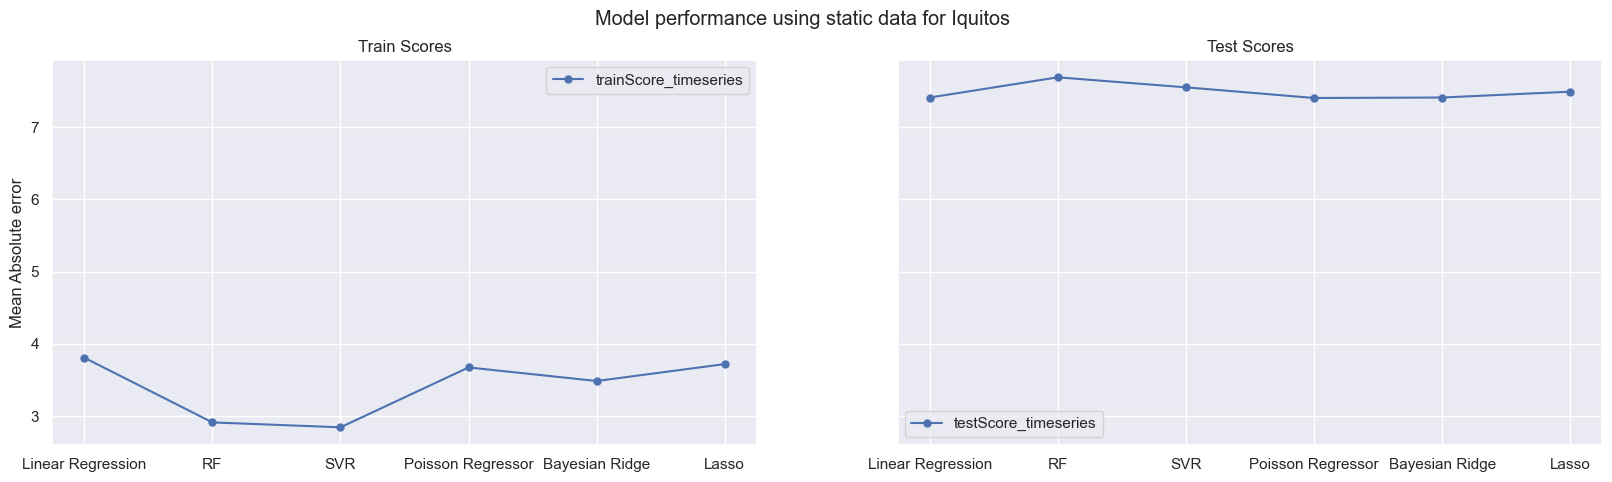

In [48]:
print('Iquitos:')
print('Time series Data:')
df = pipeline_cross_val(df_iq_time_series.drop('no_of_cases(t)', axis=1),
                   df_iq_time_series,['trainScore_timeseries','testScore_timeseries'],'no_of_cases(t)')

display(df)

fig, axs = plt.subplots(1,2,sharey=True, sharex=True)

df.loc[:,[x for x in df.columns if 'train' in x]].plot(marker='.',markersize=10,ax=axs[0],figsize=(20,5));
df.loc[:,[x for x in df.columns if 'test' in x]].plot(marker='.',markersize=10,ax=axs[1],figsize=(20,5));
axs[0].set_ylabel('Mean Absolute error');
fig.suptitle('Model performance using static data for Iquitos');
axs[0].set_title('Train Scores');
axs[1].set_title('Test Scores');

### Choosing Max Depth Parameter for Random Forest Regressor

In [49]:
# San Juan
print('San Juan')
X_train, X_test, y_train, y_test = hold_out_set(df_sj_time_series.drop('no_of_cases(t)', axis=1),
                                                df_sj_time_series,'no_of_cases(t)',
                                                0.70)

split = TimeSeriesSplit(n_splits=5)
max_depth = [1,2,3,4,5,6,7]
best_score = -999999
for md in max_depth:
    rf_sj = RandomForestRegressor(n_estimators=100,criterion='absolute_error',max_depth=md,max_features='auto')
    
    score= cross_val_score(rf_sj, X_train,y_train, cv=split, 
                           scoring='neg_mean_absolute_error')
    rf_sj.fit(X_train, y_train)
    if score[-1] > best_score:
        best_score = score[-1]
        optimal_parameter_sj = md
        optimal_model_sj = rf_sj

    print('Max depth: ',md)
    print('Scores: ',score)
    print('Training scores: ', score[-1])
    

San Juan
Max depth:  1
Scores:  [-17.43233945 -59.72917431 -32.25472477 -21.88188073 -17.19807339]
Training scores:  -17.198073394495413
Max depth:  2
Scores:  [-22.10055046 -59.99788991 -32.43889908 -21.64146789 -18.44926606]
Training scores:  -18.449266055045875
Max depth:  3
Scores:  [-22.93834862 -59.9887156  -32.78669725 -22.32201835 -19.75885321]
Training scores:  -19.758853211009175
Max depth:  4
Scores:  [-25.68183486 -60.40963303 -33.17504587 -21.82513761 -21.48357798]
Training scores:  -21.483577981651376
Max depth:  5
Scores:  [-24.97454128 -60.96444954 -34.62275229 -23.25123853 -23.03633028]
Training scores:  -23.036330275229357
Max depth:  6
Scores:  [-27.76105505 -61.37178899 -36.8143578  -22.92151376 -24.58091743]
Training scores:  -24.580917431192656
Max depth:  7
Scores:  [-28.67458716 -61.96252294 -35.87963303 -24.13137615 -27.2633945 ]
Training scores:  -27.26339449541285


In [50]:
y_pred = optimal_model_sj.predict(X_test)
print('MAE on hold out set for San Juan: ', mae(y_test, y_pred))

MAE on hold out set for San Juan:  17.23223404255319


In [51]:
# Iquitos
print('Iquitos')
X_train, X_test, y_train, y_test = hold_out_set(df_iq_time_series.drop('no_of_cases(t)', axis=1),
                                                df_iq_time_series,'no_of_cases(t)',
                                                0.70)

split = TimeSeriesSplit(n_splits=5)
max_depth = [1,2,3,4,5,6,7]
best_score = -999999
for md in max_depth:
    rf_iq = RandomForestRegressor(n_estimators=100,criterion='absolute_error',max_depth=md,max_features='auto')
    
    score= cross_val_score(rf_iq, X_train,y_train, cv=split, 
                           scoring='neg_mean_absolute_error')
    rf_iq.fit(X_train, y_train)
    if score[-1] > best_score:
        best_score = score[-1]
        optimal_parameter_iq = md
        optimal_model_iq = rf_iq

    print('Max depth: ',md)
    print('Scores: ',score)
    print('Training scores: ', score[-1])
    

Iquitos
Max depth:  1
Scores:  [-9.54566667 -4.69225    -9.44816667 -5.88966667 -2.72158333]
Training scores:  -2.7215833333333332
Max depth:  2
Scores:  [-9.52016667 -6.09541667 -8.99325    -5.62208333 -2.75541667]
Training scores:  -2.755416666666667
Max depth:  3
Scores:  [-9.50583333 -7.54216667 -8.56608333 -5.46933333 -2.87283333]
Training scores:  -2.872833333333333
Max depth:  4
Scores:  [-9.51166667 -7.45366667 -8.44383333 -5.853      -2.74258333]
Training scores:  -2.7425833333333336
Max depth:  5
Scores:  [-9.49216667 -8.25708333 -8.38683333 -6.04366667 -2.9295    ]
Training scores:  -2.9295
Max depth:  6
Scores:  [-9.48983333 -8.50583333 -8.65708333 -5.83516667 -3.39091667]
Training scores:  -3.3909166666666666
Max depth:  7
Scores:  [-9.4905     -9.01025    -8.61108333 -6.07666667 -3.23308333]
Training scores:  -3.2330833333333326


In [52]:
y_pred = optimal_model_iq.predict(X_test)
print('MAE on hold out set for Iquitos: ', mae(y_test, y_pred))

MAE on hold out set for Iquitos:  7.560063694267516


### Predicting unseen test data for the competition

In [53]:
display(df_test_features_sj.head())
display(df_test_features_iq.head())

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,260,iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,...,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
1,261,iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,...,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
2,262,iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,...,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
3,263,iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,...,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8
4,264,iq,2010,30,2010-07-30,0.306100,0.327683,0.250086,0.267914,56.30,...,18.93,78.610000,56.30,15.468571,11.771429,27.050,11.850,33.5,16.9,3.0


In [54]:
## Adding training data's last row to the first row of test data
df_test_features_sj.loc[-1] = df_train_features_sj.iloc[-1,:]  
df_test_features_sj.index = df_test_features_sj.index + 1  # shifting index
df_test_features_sj.sort_index(inplace=True) 

df_test_features_sj.head()

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,935,sj,2008,17,2008-04-22,-0.0370,-0.010367,0.077314,0.090586,0.00,...,2.17,76.960000,0.00,15.671429,3.957143,27.042857,7.514286,31.7,23.3,0.3
1,0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
2,1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
3,2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
4,3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3


In [55]:
## Adding training data's last row to the first row of test data
df_test_features_iq.loc[-1] = df_train_features_iq.iloc[-1,:]  
df_test_features_iq.index = df_test_features_iq.index + 1  # shifting index
df_test_features_iq.sort_index(inplace=True) 

df_test_features_iq.head()

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,1455,iq,2010,25,2010-06-25,0.298186,0.232971,0.274214,0.315757,63.22,...,36.90,89.082857,63.22,17.355714,11.014286,27.475,9.900,33.7,22.2,20.4
1,260,iq,2010,26,2010-07-02,0.183783,0.142500,0.225129,0.150214,82.29,...,34.11,92.581429,82.29,17.654286,9.428571,27.440,10.760,33.8,21.5,11.2
2,261,iq,2010,27,2010-07-09,0.291657,0.272267,0.330700,0.320914,25.30,...,9.10,83.885714,25.30,16.320000,10.157143,27.025,9.625,33.0,21.2,8.9
3,262,iq,2010,28,2010-07-16,0.208543,0.366457,0.212629,0.255514,62.14,...,61.09,92.057143,62.14,18.030000,9.557143,26.950,10.350,33.4,21.6,22.6
4,263,iq,2010,29,2010-07-23,0.089286,0.063214,0.122057,0.081957,47.80,...,19.60,88.970000,47.80,15.394286,7.828571,26.900,9.700,33.3,14.2,4.8


In [56]:
percent_missing_sj = 100*df_test_features_sj.isnull().sum()/len(df_test_features_sj)
percent_missing_iq = 100*df_test_features_iq.isnull().sum()/len(df_test_features_iq)
df_missing_stats = pd.DataFrame({'precent_missing_sj' : percent_missing_sj, 
                                 'precent_missing_iq' : percent_missing_iq})
df_missing_stats.transpose()

,index,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
precent_missing_sj,0.0,0.0,0.0,0.0,0.0,16.475096,4.214559,0.383142,0.383142,0.766284,...,0.766284,0.766284,0.766284,0.766284,0.766284,0.766284,0.766284,0.766284,0.766284,0.766284
precent_missing_iq,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,6.369427,6.369427,0.636943,4.458599,1.910828


In [57]:
df_test_features_sj_imputed = impute(df_test_features_sj.copy(),'precent_missing_sj',False)
df_test_features_iq_imputed = impute(df_test_features_iq.copy(),'precent_missing_iq',False)
df_test_features_imputed = pd.concat([df_test_features_sj_imputed,df_test_features_iq_imputed])

In [58]:
df_sj_time_series_test = df_test_features_sj_imputed.loc[:,top_10_features_sj_static]
lagged_cols, lagged_col_names = list(), list()
for i in range(1, 0, -1):
    lagged_cols.append(df_sj_time_series_test.shift(i))
    lagged_col_names += [('%s(t-%d)' % (j, i)) for j in top_10_features_sj_static]

df_sj_time_series_test  = pd.concat(lagged_cols, axis=1)
df_sj_time_series_test.columns = lagged_col_names
df_sj_time_series_test.dropna(inplace=True)
df_sj_time_series_test.head()

,ndvi_se(t-1),station_avg_temp_c(t-1),ndvi_ne(t-1),ndvi_sw(t-1),reanalysis_dew_point_temp_k(t-1),reanalysis_precip_amt_kg_per_m2(t-1),station_precip_mm(t-1),ndvi_nw(t-1),reanalysis_relative_humidity_percent(t-1),reanalysis_tdtr_k(t-1)
1,0.077314,27.042857,-0.037000,0.090586,294.280000,2.17,0.3,-0.010367,76.960000,3.957143
2,0.102729,26.528571,-0.018900,0.091200,294.527143,25.37,75.2,-0.018900,78.781429,3.128571
3,0.082043,26.071429,-0.018000,0.072314,294.395714,21.83,34.3,-0.012400,78.230000,2.571429
4,0.151083,27.928571,-0.001500,0.091529,295.308571,4.12,3.0,0.013400,78.270000,4.428571
5,0.124329,28.057143,0.008787,0.125686,294.402857,2.20,0.3,-0.019867,73.015714,4.342857


In [60]:
df_iq_time_series_test = df_test_features_iq_imputed.loc[:,top_10_features_iq_static]
lagged_cols, lagged_col_names = list(), list()
for i in range(1, 0, -1):
    lagged_cols.append(df_iq_time_series_test.shift(i))
    lagged_col_names += [('%s(t-%d)' % (j, i)) for j in top_10_features_iq_static]

df_iq_time_series_test  = pd.concat(lagged_cols, axis=1)
df_iq_time_series_test.columns = lagged_col_names
df_iq_time_series_test.dropna(inplace=True)
df_iq_time_series_test.head()

,reanalysis_max_air_temp_k(t-1),station_max_temp_c(t-1),reanalysis_min_air_temp_k(t-1),station_min_temp_c(t-1),station_precip_mm(t-1),reanalysis_precip_amt_kg_per_m2(t-1),ndvi_nw(t-1),reanalysis_specific_humidity_g_per_kg(t-1),station_diur_temp_rng_c(t-1),reanalysis_dew_point_temp_k(t-1)
1,307.8,33.7,292.3,22.2,20.4,36.90,0.232971,17.355714,9.900,295.807143
2,307.9,33.8,293.7,21.5,11.2,34.11,0.142500,17.654286,10.760,296.118571
3,307.7,33.0,292.2,21.2,8.9,9.10,0.272267,16.320000,9.625,294.831429
4,306.4,33.4,292.5,21.6,22.6,61.09,0.366457,18.030000,10.350,296.417143
5,306.4,33.3,289.3,14.2,4.8,19.60,0.063214,15.394286,9.700,293.638571


In [66]:
y_pred_test_sj = np.ceil(optimal_model_sj.predict(df_sj_time_series_test))
y_pred_test_iq = np.ceil(optimal_model_iq.predict(df_iq_time_series_test))
y_predictions = np.append(y_pred_test_sj, y_pred_test_iq)
submission['total_cases'] = y_predictions
submission['total_cases'] = pd.to_numeric(submission['total_cases'], downcast='integer')

In [67]:
submission.to_csv('data/submission1.csv', index=False)

### Submission 2

In [68]:
svc_sj = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.5))
X_train, X_test, y_train, y_test = hold_out_set(df_sj_time_series.drop('no_of_cases(t)', axis=1),df_sj_time_series,'no_of_cases(t)',0.70)
model_sj = svc_sj.fit(X_train,y_train)

y_pred_test_sj = np.ceil(model_sj.predict(df_sj_time_series_test))

svc_iq = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.5))
X_train, X_test, y_train, y_test = hold_out_set(df_iq_time_series.drop('no_of_cases(t)', axis=1),df_iq_time_series,'no_of_cases(t)',0.70)
model_iq = svc_iq.fit(X_train,y_train)

y_pred_test_iq = np.ceil(optimal_model_iq.predict(df_iq_time_series_test))

y_predictions = np.append(y_pred_test_sj, y_pred_test_iq)
submission['total_cases'] = y_predictions
submission['total_cases'] = pd.to_numeric(submission['total_cases'], downcast='integer')

In [70]:
submission.to_csv('data/submission2.csv', index=False)